In [1]:
%matplotlib inline

In [2]:
# Basic imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import re
from datetime import datetime

import os
from os import path

import joblib
import cv2

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Plotting

import IPython.display as ipd

import seaborn as sns 
sns.set_style("darkgrid")
colors = sns.color_palette("coolwarm_r")

palette = [
    "#A79AFF", "#AFCBFF", "#FF9CEE", "#FFCCF9", 
    "#85E3FF", "#ACE7FF", "#AFF8DB", "#DBFFD6", 
    "#E7FFAC", "#FFFFD1", "#FFABAB", "#FFCBC1" 
]

m_color, f_color = "#FFABAB", "#AFCBFF"

In [4]:
# Audio procesing

from scipy.io import wavfile
import noisereduce as nr
import pydub
from pydub import AudioSegment
import subprocess
import librosa
import librosa.display as ld

from pyAudioAnalysis import audioBasicIO as aIO
from pyAudioAnalysis import MidTermFeatures as MTF

In [5]:
# Stats and Modeling

from imblearn.under_sampling import RandomUnderSampler

from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler

import shap

from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from sklearn.pipeline import Pipeline

import optuna

from sklearn.model_selection import cross_val_score, learning_curve, train_test_split, KFold, cross_validate

from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, make_scorer, log_loss
from sklearn.metrics import precision_score, f1_score, brier_score_loss, roc_curve, roc_auc_score, plot_roc_curve

# Sentiment Analysis of Audio Data

#### An end-to-end project for audio machine learning’s foundational application scenario.

### Author: Tihomir Todorov

<br>
<a href="https://imgur.com/31B44bW"><img src="https://i.imgur.com/31B44bW.jpg" title="source: imgur.com" width="800px"/></a><br>

<a name = "introduction"></a> 

## 1. Introduction

It is common to see a data science project on image, text or tabular data, but no as often we see such on analyzing audio data. In this project, we will explore how to do that. How to prepare, explore, analyze data, and apply machine learning models to predict certain features. In short: As for all other modalities as well, the "problem" always is to get the data into an interpretable format.

The interesting thing with audio data is that you can treat it as a different modality:

- Extract high-level features and analyze the data in a tabular format.

    
- Compute frequency plots and inspect the data like image data.


- Use temporal sensitive models to treat the data like time-series data, etc...

In this noteobok we will look at those three approaches.

<br>

### 1.1 Motivation

I am a musician and a producer, this has been my hobby for many years now, and I am extremely curious about sound, voice, frequencies and their application in Data Science and Machine Learning. Furthermore, I have huge interest in psychology and understanding how A.I can understand sound and voice is going to take a big part in my future career development as a Data Scientist. I realized that besides playing on an instrument or composing virtual sounds, there is a lot to be investigated and explored in the area of sound, and decided to use this project in order to gather a bigger understanding of how sounds are constructed.

<br>

### 1.2 Previous Research

This project was inspired by Michael P. Notter's research published at [Medium](https://medium.com/epfl-extension-school/age-prediction-of-a-speakers-voice-ae9173ceb322)

I decided to improve and expand this research and learn from the great skills of an experienced data professional. Other inspirations and resources will be included at the end of this notebook.

<br>

### 1.3 Our Dataset

For this project we will use the Mozilla's Common Voice 11.0 dataset:

Common Voice is a corpus of speech data read by users on the Common Voice website (http://voice.mozilla.org/), and based upon text from a number of public domain sources like user submitted blog posts, old books, movies, and other public speech corpora. Its primary purpose is to enable the training and testing of automatic speech recognition (ASR) systems.

- **The corpus contains 2,161,672 audio files and various .tsv (tab-separated values) files.**

<br>

### 1.4 The Structure

The corpus is split into several parts for our convenience.

- dev - for development and experimentation
- train - for use in speech recognition training
- test - for testing word error rate

<br>

### 1.5 Organization and Conventions


Each row of a csv file represents a single audio clip, and contains the following information:

    filename - relative path of the audio file
    
    text - supposed transcription of the audio
    
    up_votes - number of people who said audio matches the text
    
    down_votes - number of people who said audio does not match text
    
    age - age of the speaker, if the speaker reported it
        teens: '< 19'
        twenties: '19 - 29'
        thirties: '30 - 39'
        fourties: '40 - 49'
        fifties: '50 - 59'
        sixties: '60 - 69'
        seventies: '70 - 79'
        eighties: '80 - 89'
        nineties: '> 89'
    
    gender - gender of the speaker, if the speaker reported it
        male
        female
        other
    
    accent - accent of the speaker, if the speaker reported it
        us: 'United States English'
        australia: 'Australian English'
        england: 'England English'
        canada: 'Canadian English'
        philippines: 'Filipino'
        hongkong: 'Hong Kong English'
        indian: 'India and South Asia (India, Pakistan, Sri Lanka)'
        ireland: 'Irish English'
        malaysia: 'Malaysian English'
        newzealand: 'New Zealand English'
        scotland: 'Scottish English'
        singapore: 'Singaporean English'
        southatlandtic: 'South Atlantic (Falkland Islands, Saint Helena)'
        african: 'Southern African (South Africa, Zimbabwe, Namibia)'
        wales: 'Welsh English'
        bermuda: 'West Indies and Bermuda (Bahamas, Bermuda, Jamaica, Trinidad)'


- **The audio clips for each subset are stored as mp3 files in the "clip" folder with the same naming conventions as it’s corresponding csv file.**


<br>

### 1.6 Acknowledgments

This dataset was compiled by Michael Henretty, Tilman Kamp, Kelly Davis & The Common Voice Team, who included the following acknowledgments:

"We sincerely thank all of the people who donated their voice on the Common Voice website and app. You are the backbone of this project, and we thank you for making this possible!"

<br>

<a name = "data_cleaning"></a>
## 2. Data Cleaning

We will be using [librosa](https://librosa.org/doc/main/index.html) to load and visualize audio data and some of it's features. Librosa is a python package for audio and music analysis.




#### Note: 

We can experience a problem when loading the files in librosa as mp3, so let's learn something useful, how to convert .mp3 to .wav in python :) As there are more than 2,161,672 files (excluding the ones with missing value for "gender"), this will be a long process...

- That's why it will be a good idea to reduce our audio data to the amount of observations that contain "gender" information and then see if the classes are imbalanced. If they are, we will most probably undersample and equalize the classes in order to reduce the audio even further.


- Our goal is to obtain aproximately 200,000 observations out of over 2 million, and all of them should contain gender information.

In [6]:
valid_data = pd.read_csv("original-csv/validated.tsv", sep = "\t")

In [7]:
valid_data.head()

client_id  \
0  000abb3006b78ea4c1144e55d9d158f05a9db011016051...   
1  0013037a1d45cc33460806cc3f8ecee9d536c45639ba4c...   
2  0014c5a3e5715a54855257779b89c2bb498d470b225866...   
3  001509f4624a7dee75247f6a8b642c4a0d09f8be3eeea6...   
4  001519f234e04528a2b36158c205dbe61c8da45ab0242f...   

                           path  \
0  common_voice_en_27710027.mp3   
1    common_voice_en_699711.mp3   
2  common_voice_en_21953345.mp3   
3  common_voice_en_18132047.mp3   
4  common_voice_en_27340672.mp3   

                                            sentence  up_votes  down_votes  \
0  Joe Keaton disapproved of films, and Buster al...         3           1   
1                               She'll be all right.         2           1   
2                                                six         3           2   
3                         All's well that ends well.         2           0   
4  It is a busy market town that serves a large s...         2           0   

   age gender accents locale    segment  
0  NaN    NaN     NaN     en        NaN  
1  NaN    NaN     NaN     en        NaN  
2  NaN    NaN     NaN     en  Benchmark  
3  NaN    NaN     NaN     en        NaN  
4  NaN    NaN     NaN     en        NaN

In [8]:
valid_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1617877 entries, 0 to 1617876
Data columns (total 10 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   client_id   1617877 non-null  object
 1   path        1617877 non-null  object
 2   sentence    1617877 non-null  object
 3   up_votes    1617877 non-null  int64 
 4   down_votes  1617877 non-null  int64 
 5   age         1040402 non-null  object
 6   gender      1042845 non-null  object
 7   accents     861134 non-null   object
 8   locale      1617877 non-null  object
 9   segment     32726 non-null    object
dtypes: int64(2), object(8)
memory usage: 123.4+ MB


In [9]:
valid_data.gender.isna().value_counts()

False    1042845
True      575032
Name: gender, dtype: int64

- We see that out of 1,617,877 valid audios 575,032 do not contain gender information, therefore we will remove them from the dataset and later from the audio folder.

In [10]:
valid_data = valid_data[valid_data.gender.notna()]

- As a next step, we should check if our genders are balanced and see if we can reduce the data by undersampling:

In [11]:
def plot_countplot(data, x, figsize, title, xlabel, ylabel):
    plt.figure(figsize = figsize)
    sns.countplot(x = x, data = data, palette = colors)
    
    plt.title(title, fontsize = 14)
    plt.xlabel(xlabel, fontsize = 10)
    plt.ylabel(ylabel, fontsize = 10)
    
    plt.show()

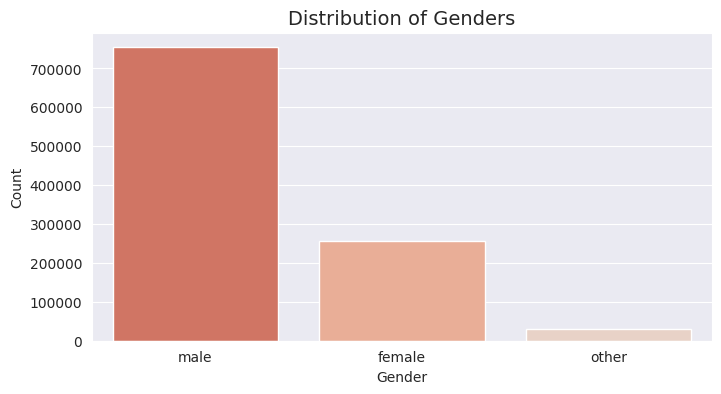

In [12]:
plot_countplot(valid_data, x = "gender", figsize = (8, 4), title = "Distribution of Genders", xlabel = "Gender", ylabel = "Count")

In [13]:
valid_data.gender.value_counts()

male      754279
female    257655
other      30911
Name: gender, dtype: int64

- Plenty of disbalance, but that will work for our target of 200k samples.


- Let's remove the "other" records first:

In [14]:
valid_data = valid_data[valid_data.gender != "other"]

- Now we can undersample the dataset so we have 250k records from each:

In [15]:
under_sampler = RandomUnderSampler(sampling_strategy = "majority", random_state = 42)

In [16]:
def majority_under_sampler(data):
    under_sampler = RandomUnderSampler(sampling_strategy = "majority", random_state = 42)

    data_X, data_Y = under_sampler.fit_resample(data.drop("gender", axis = 1).reset_index(drop = True), data.gender)

    balanced_data = pd.concat([pd.DataFrame(data_Y), pd.DataFrame(data_X)], axis = 1)
    
    return balanced_data

In [17]:
balanced_data = majority_under_sampler(valid_data)

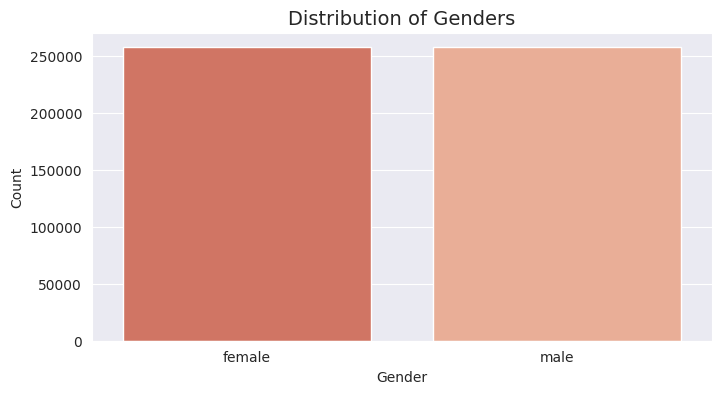

In [18]:
plot_countplot(balanced_data, x = "gender", figsize = (8, 4), title = "Distribution of Genders", xlabel = "Gender", ylabel = "Count")

- Good to go! We have more than 500k observations from which we can take a sample to "feed" our model with. Let's remove the columns that we are not going to use and save our file!

In [19]:
# balanced_data = balanced_data[["gender", "path"]]

In [20]:
# balanced_data.to_csv("balanced_data.csv", index = False)

In [21]:
balanced_data = pd.read_csv("balanced_data.csv")

Now we can take a sample from this file.

In [22]:
sample = balanced_data.sample(n = 200000, random_state = 88)

In [23]:
sample.gender.value_counts()

male      100242
female     99758
Name: gender, dtype: int64

The number of men and women in the world is roughly equal, though men hold a slight lead with 102 men for 100 women. More precisely, out of 1,000 people, 504 are men (50.4%) and 496 are women (49.6%).

That's why this a very good representation of the population in this sample.

In [24]:
# sample.to_csv("balanced_sample.csv", index = False)

In [25]:
data_sample = pd.read_csv("balanced_sample.csv")

In [26]:
data_sample.head(3)

gender                          path
0   male  common_voice_en_25083267.mp3
1   male    common_voice_en_134492.mp3
2   male  common_voice_en_18296826.mp3

We can now rename the "path" column to "filename" because it is more accurate description.

In [27]:
data_sample.rename(columns = {"path": "filename"}, inplace = True)

Perfect! We are ready for the next step... Deleting the unneeded audio from our audio folder.

In [28]:
def delete_unmatched_files(path, data):

    os.chdir(path)
    audio_files = os.listdir()
    files_deleted = 0

    for file in audio_files:
        name, extension = os.path.splitext(file)
        if file not in data.path.to_list():
            os.remove(file)
            files_deleted += 1
            
    os.chdir(CSV_PATH)
    print(f"{files_deleted} unmatched files deleted from this folder.")

In [29]:
# delete_unmatched_files(AUDIO_PATH, data_sample)
'''1,971,879 unmatched files deleted from this folder.'''

'1,971,879 unmatched files deleted from this folder.'

In [30]:
def convert_mp3_to_wav(path, data):
    # Create a list with the filenames
    new_path = os.chdir(path)
    audio_files = os.listdir(new_path)

    for file in audio_files:
        # Split the file into the name and the extension
        name, extension = os.path.splitext(file)
        if file in data.path.to_list():
            if extension == ".mp3":
                mp3_sound = AudioSegment.from_mp3(file)
               # Convert and rename the files using the old name + ".wav"
                mp3_sound.export("{0}.wav".format(name), format = "wav")
                


In [31]:
# convert_mp3_to_wav(AUDIO_PATH, data_sample)

- Now that we were patient enough to wait for the conversion, Let's delete the remaining mp3 files and leave only the .wav audios:

In [32]:
def delete_mp3_files(path):

    os.chdir(path)
    audio_files = os.listdir()
    files_deleted = 0

    for file in audio_files:
        name, extension = os.path.splitext(file)
        if extension == ".mp3":
            os.remove(file)
            files_deleted += 1
            
    os.chdir(CSV_PATH)
    print(f"{files_deleted} .mp3 files deleted from this folder.")

In [33]:
# delete_mp3_files(AUDIO_PATH)
'''200,000 .mp3 files deleted from this folder.'''

'200,000 .mp3 files deleted from this folder.'

<a name = "eda"></a>

## 3. Exploring the Facets of Audio by Gender 

<br>

We are ready to continue, but before extracting and exploring our features, let's first investigate the many facets of audio files. We will need to do this, in order to understand our data and our future work better.

#### By default, librosa resamples the audio file on loading to 22050 Hz. But why?

It's true: $44100 Hz$ is essentially the standard for "high (enough) quality" audio storage, and it would have been a sensible default. However, they decided for the lower rate of $22050 Hz$ for two reasons:

- It cuts down on memory consumption
    

- $44100$ was overkill for the most common tasks

The first point is obvious, but the second point deserves a bit more discussion:

- The highest pitches we usually care about detecting are around $C_9 \approx 8372 Hz$, well below the $11025$ cutoff implied by $fs = 22050$. There's certainly content above $11025 Hz$, but it often turns out to be noisy or redundant with the lower parts of the spectrum, and not so informative for semantic analysis tasks like instrument classification, rhythm analysis, chord recognition, and so on


- More info [here](https://librosa.org/blog/2019/07/17/resample-on-load/)

__Note__:

Due to the conversion of each audio file before loading it, __performing feature exctraction with librosa turns out to be a very slow process for large amounts of data__, as previously tested. That's why we will use another library for that, which we will discuss later.

<br>

__Note:__ 

__After reading the metadata of our dataset, we can find that many of the audios have the same words, but either different gender or accent, this will be useful to us. We have pre-selected such two audio files with the same text, but different gender and we will explore the audio characteristics of each, to see what insight we can gain.__


When you load a sample in librosa it automatically divides it in two files:

1. Audio time series. Multi-channel is supported


2. The sampling rate (sr) of the file

In [34]:
audio_male, sr_male = librosa.load("test_audio/sample-037769.wav")
audio_female, sr_female = librosa.load("test_audio/sample-000410.wav")

In [35]:
audio_male, audio_female

(array([ 0.        ,  0.        ,  0.        , ..., -0.00100381,
         0.00369414,  0.        ], dtype=float32),
 array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 3.1845491e-06,
        2.2952217e-05, 0.0000000e+00], dtype=float32))

In [36]:
sr_male, sr_female

(22050, 22050)

- We can see that the audio is returned in float32 type array and the default sample rate is 22050

#### Let's use the IPython.display.Audio to play the random file

In [37]:
ipd.display(ipd.Audio(audio_male, rate = sr_male), ipd.Audio(audio_female, rate = sr_female))

- We can also plot the signal stored in the audio_file variable

In [38]:
 def plot_waveform_signal(audio, sr, title, color):

    plt.figure(figsize = (8, 2))

    ld.waveshow(audio, sr = sr, color = color, alpha = 0.7)

    plt.title(title, fontsize = 12)
    plt.xlabel("Time (s)", fontsize = 10)
    plt.ylabel("Amplitude (dB)", fontsize = 10)

    plt.show()

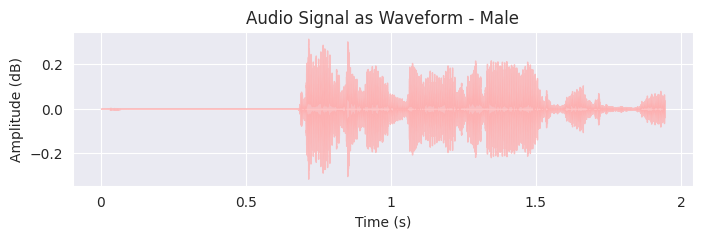

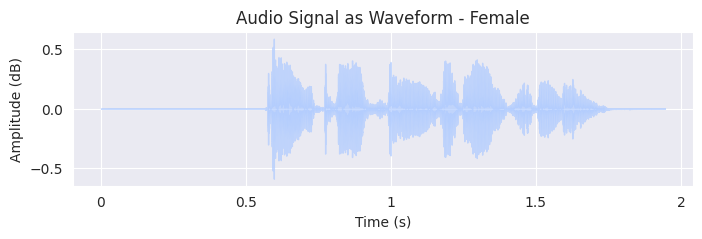

None

None

In [39]:
ipd.display(
    plot_waveform_signal(
        audio = audio_male, 
        sr = sr_male,
        title = "Audio Signal as Waveform - Male",
        color = m_color
    ), 
        plot_waveform_signal(
        audio = audio_female, 
        sr = sr_female,
        title = "Audio Signal as Waveform - Female",
        color = f_color
    )
)

#### What we see here is the **waveform** representation of the spoken sentence: “Don't take any chances”

The amplitude of the female audio reaches higher and lower numbers. This amplitude shows us the relative strength of sound waves (transmitted vibrations), which we perceive as loudness or volume.

- If you play both audios a few times, you can notice that this difference in amplitude is not really easy to perceive by the human ear.


- You can see the obvious difference caused by pronouncing the words in distinct ways, especially the last word - "chances" that looks as two words in the male plot, but it is actually one, just pronounced differently.

<br>
 
Ok, so, first we called it time-series data, but now we name it waveform? Well, it is both. This becomes clearer when we look only at a small segment of this audio file. The following plot shows the same thing as above, but this time only $45$ milliseconds of it.

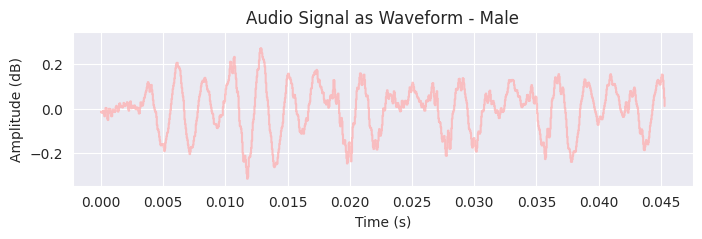

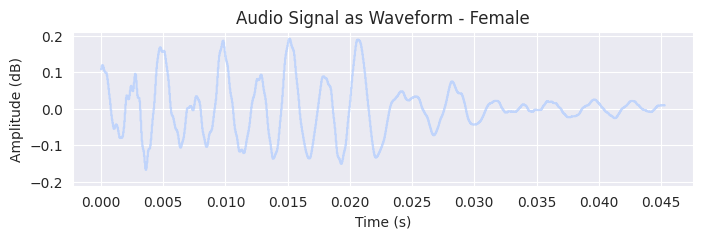

None

None

In [40]:
ipd.display(
    plot_waveform_signal(
        audio = audio_male[15500 : 16500], 
        sr = sr_male,
        title = "Audio Signal as Waveform - Male",
        color = m_color
    ), 
        plot_waveform_signal(
        audio = audio_female[15500 : 16500], 
        sr = sr_female,
        title = "Audio Signal as Waveform - Female",
        color = f_color
    )
)

What we can see is a temporal signal that oscillates around the value 0 with different frequencies and amplitudes.This signal represents the air pressure change over time, or the physical displacement of a loud speaker’s membrane (or the membrane in your ear for that matter). That’s why this depiction of the audio data is also called waveform.


- The frequency is the speed with which this signal oscillates. Low frequency, e.g. $60 Hz$ could be the sound of bass guitar, while a birds song could be in the higher frequency of $8000 Hz$. Human speech is usually anywhere between that.


- To know the interpretation speed of this signal, we also need to know the sampling rate at which the data was recorded. In this case, the sampling rate (after resampling from librosa) per second is $22.050$ or $22 kHz$. Which means that the $1.000$ time points we can see in the previous figure represents $45$ milliseconds $(1000 / 22.050 \approxeq 0.045)$ of audio signal.


- Seems that the male's voice frequency oscillates faster around the 0 line, this might be helpful to know.


<br>

### 3.1.1 The Fast Fourier Transform

- While the previous visualization can tell us when something happens (i.e. between 1 and 5 seconds there seem to be a lot of waveforms), it cannot really tell us with what frequency it happens. Because the waveform shows us information about the when, this signal is also said to be in the time domain

#### The Fast-Fourier transform is a mathematical formula that allows us to decompose a signal into it’s individual frequencies and the frequency’s amplitude. In other words, it converts the signal from the time domain into the frequency domain. The result is called a spectrum:

<br>

<div>
<a href="https://imgur.com/Z833qxp"><img src="https://i.imgur.com/Z833qxp.jpg" title="source: imgur.com" width = "840px"/></a>
</div>

#### This is possible because every signal can be decomposed into a set of sine and cosine waves that add up to the original signal. This is a remarkable theorem known as [Fourier’s theorem](https://www.sfu.ca/sonic-studio-webdav/handbook/Fourier_Theorem.html).

<br>

#### Let’s see what our sentence from before looks like, represented in the frequency domain:

In [41]:
def plot_fft(audio, sr, title, color):
    # Applies fast fourier transformation to the signal and takes absolute values
    sample_freq = np.abs(scipy.fftpack.fft(audio))

    # Adding a wrapper around the plot which additionally changes the x-axis to log scaling
    frequencies = np.linspace(0, sr, len(sample_freq))

    plt.figure(figsize = (8, 2))
    plt.semilogx(
        frequencies[: len(frequencies) // 2], 
        sample_freq[: len(frequencies) // 2], 
        color = color, 
        alpha = 0.7
    )
               
    plt.title(title, fontsize = 12)
    plt.xlabel("Frequency (Hz)", fontsize = 10)
    plt.ylabel("Amplitude", fontsize = 10)

    plt.show()

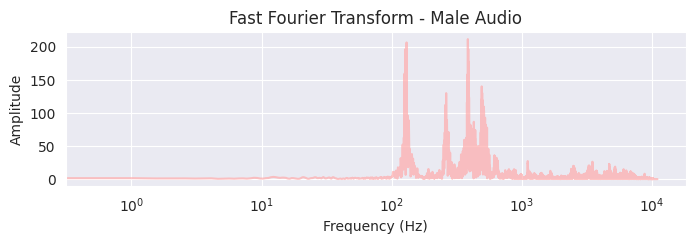

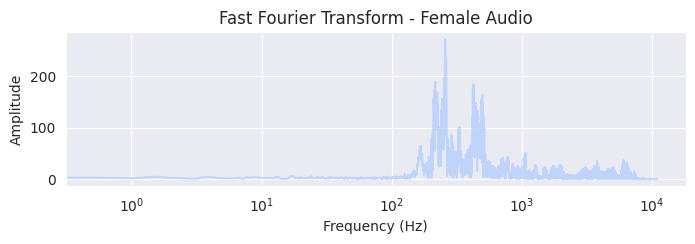

None

None

In [42]:
ipd.display(
    plot_fft(
        audio = audio_male,
        sr = sr_male,
        title = "Fast Fourier Transform - Male Audio",
        color = m_color
    ),
    plot_fft(
        audio = audio_female,
        sr = sr_female,
        title = "Fast Fourier Transform - Female Audio",
        color = f_color
    )
)

What you can see here is that most of the signal is somewhere between $~100 \space and ~1000 Hz$ (i.e. between $10^2$ and $10^3$). Plus there seem to be some additional signals from 1’000 to 10’000 Hz that are stronger in the female voice.

- That makes sense, as female voice is generally produces higher frequencies than male.

<br>

<a name = "spectrogram"></a>
### 3. 1. 2 Spectrograms

Luckily, we don’t always need to decide for either the time or frequency domain. Using a spectrogram plot, we can profit from both domains, while keeping most of their handicaps minimal. There are multiple ways how you can create such spectrogram plots, but for this project we will explore two of them in particular:

<br>
<a name = "stft"></a>

#### Short-Time Fourier Transform

Using a small, adapted version of the fast fourier transformation before, namely the short-time fourier transformation, we can create such a spectrogram. STFT works as the fast fourier transforms are computed for multiple small time windows (hence “short-time fourier”) in a sliding window manner.

In [43]:
def plot_stft(audio, sr, title):
    # Compute short-time Fourier Transform
    x_stft = np.abs(librosa.stft(audio))

    # Apply logarithmic dB-scale to spectrogram and set maximum to 0 dB
    x_stft = librosa.amplitude_to_db(x_stft, ref = np.max)

    # Plot STFT spectrogram
    plt.figure(figsize = (6, 3))

    ld.specshow(x_stft, sr = sr, x_axis = "time", y_axis = "log", cmap = "coolwarm")
    plt.colorbar(format = "%+2.0f dB")
    
    plt.title(title, fontsize = 12)
    plt.xlabel("Time (s)", fontsize = 10)
    plt.ylabel("Frequency (Hz)", fontsize = 10)

    plt.show()

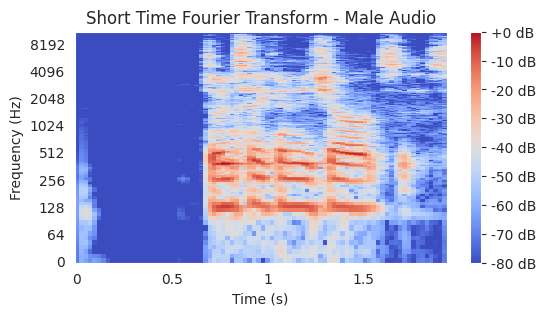

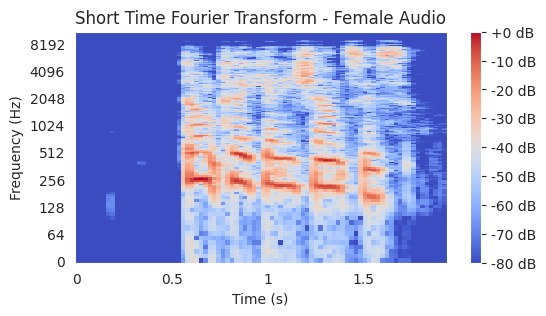

None

None

In [44]:
ipd.display(
    plot_stft(
        audio = audio_male,
        sr = sr_male,
        title = "Short Time Fourier Transform - Male Audio"
    ),
    plot_stft(
        audio = audio_female,
        sr = sr_female,
        title = "Short Time Fourier Transform - Female Audio"
    )
)


- In all spectrogram plots, the color represents the amount (loudness/volume) of a given frequency, at a given timepoint. +0dB is the loudest, and -80dB is close to silence. On the horizontal x-axis we can see the time, while on the vertical y-axis we can see the different frequencies.


- This plot shows, that the female voice is generally stronger on the higher frequencies (256-512Hz) and the male voice is stronger in the lower (around 128Hz) frequencies.

<br>
<a name = "mel"></a>

#### The Mel Spectrogram

As an alternative to the STFT, we can also compute the mel spectrogram, which is based on the [mel scale](https://www.sfu.ca/sonic-studio-webdav/handbook/Mel.html). This scale accounts for the way we human perceive a sound’s pitch. The mel scale is calculated so that two pairs of frequencies separated by a delta in the mel scale are perceived by humans as having the same perceptual difference.

- The mel spectrogram is computed very similar to the STFT, the main difference is just that the y-axis uses a different scale.

In [45]:
def plot_mel_spectrogram(audio, sr, title):
    x_mel = librosa.feature.melspectrogram(y = audio, sr = sr)

    # Apply logarithmic dB-scale to spectrogram and set maximum to 0 dB
    x_mel = librosa.power_to_db(x_mel, ref = np.max)

    plt.figure(figsize = (6, 3))
    ld.specshow(x_mel, sr = sr, x_axis = "time", y_axis = "mel", cmap = "coolwarm")
    plt.colorbar(format = "%+2.0f dB")
    
    plt.title(title, fontsize = 12)
    plt.xlabel("Time (s)", fontsize = 10)
    plt.ylabel("Frequency (Hz)", fontsize = 10)
    plt.show()

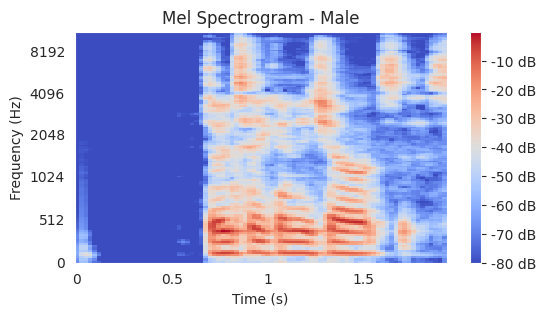

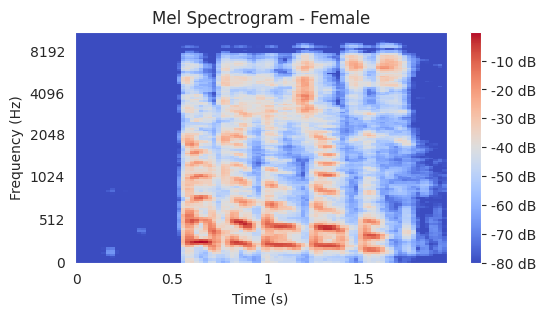

None

None

In [46]:
ipd.display(
    plot_mel_spectrogram(
        audio = audio_male,
        sr = sr_male,
        title = "Mel Spectrogram - Male"
    ),
    plot_mel_spectrogram(
        audio = audio_female,
        sr = sr_female,
        title = "Mel Spectrogram - Female"
    )
)

- The difference to the STFT might not be too obvious first, but if we take a closer look, we can see that in the STFT plot, the frequency from 0 to 512 Hz take much more space on the y-axis than in the Mel plot.

__Note: We are not going to explore all the audio features that we will use in our model in order to save some time and focus on the modelling. Later we will shortly introduce each feature with some general information of it.__

<br>


#### We saw how our audio features can help our model recognize the speaker's gender, let's now see how to extract those features in the fastest and most effective way.

<br>

<a name = "feature_extraction"></a>
## 4. Feature Extraction

In this part we will use the [pyAudioAnalysis](https://github.com/tyiannak/pyAudioAnalysis/wiki) library - an open-source Python library that provides a wide range of audio-related functionalities focusing on feature extraction, classification, segmentation and visualization issues.

There are two stages in the audio feature extraction methodology:

- __Short-term feature extraction__: It splits the input signal into short-term widnows (frames) and computes a number of features for each frame. This process leads to a sequence of short-term feature vectors for the whole signal.


- __Mid-term feature extraction__: In many cases, the signal is represented by statistics on the extracted short-term feature sequences described above. Towards this end, function mid_feature_extraction() from the MidTermFeatures.py file extracts a number of statistcs (e.g. mean and standard deviation) over each short-term feature sequence.


#### We will use the second type of extraction to gain more information from our data. Those are the implemented features that we will extract:

    1. Zero Crossing Rate  - The rate of sign-changes of the signal during the duration of a particular frame.

    2. Energy - The sum of squares of the signal values, normalized by the respective frame length.
    
    3. Entropy of Energy - The entropy of sub-frames' normalized energies. It can be interpreted as a measure of abrupt changes.
    
    4. Spectral Centroid - The center of gravity of the spectrum.
    
    5. Spectral Spread - The second central moment of the spectrum.
    
    6. Spectral Entropy - Entropy of the normalized spectral energies for a set of sub-frames.

    7. Spectral Flux - The squared difference between the normalized magnitudes of the spectra of the two successive frames.

    8. Spectral Rolloff - The frequency below which 90% of the magnitude distribution of the spectrum is concentrated.
    
    9. MFCCs - Mel Frequency Cepstral Coefficients form a cepstral representation where the frequency bands are not linear but distributed according to the mel-scale.

    10. Chroma Vector - A 12-element representation of the spectral energy where the bins represent the 12 equal-tempered pitch classes of western-type music (semitone spacing).
    
    11. Chroma Deviation - The standard deviation of the 12 chroma coefficients.
    
<br>

<br>

#### Now let's go ahead and write a function to extract our mid-term features.

In [47]:
def mt_feature_extractor(path):
    features, files, feature_names = MTF.directory_feature_extraction(path, 1, 1, 0.1, 0.05, compute_beat = False)

    df = pd.DataFrame(features, columns = feature_names)
    df["filename"] = [file for file in files]
    
    return df

- We can now apply our function and extract all the features from the audio folder:

In [48]:
# data_features = mt_feature_extractor(AUDIO_PATH)

- And finally, let's save the extracted features, so we don't need to execute the previous functions anew...

In [49]:
# data_features.to_csv("data_features.csv", index = False)

In [50]:
data_features = pd.read_csv("data_features.csv")

In [51]:
data_features.head(3)

zcr_mean  energy_mean  energy_entropy_mean  spectral_centroid_mean  \
0  0.077827     0.007320             3.014060                0.132813   
1  0.045221     0.008500             2.671475                0.103600   
2  0.033737     0.017603             2.864653                0.097736   

   spectral_spread_mean  spectral_entropy_mean  spectral_flux_mean  \
0              0.149789               0.663245            0.004220   
1              0.150678               0.276039            0.006642   
2              0.152176               0.213714            0.006735   

   spectral_rolloff_mean  mfcc_1_mean  mfcc_2_mean  ...  delta chroma_5_std  \
0               0.128198   -28.011140     2.196524  ...            0.008914   
1               0.060947   -28.252479     2.999446  ...            0.012845   
2               0.050877   -26.568604     2.691409  ...            0.007033   

   delta chroma_6_std  delta chroma_7_std  delta chroma_8_std  \
0            0.013670            0.008552            0.002604   
1            0.009056            0.004697            0.004424   
2            0.006790            0.005256            0.004136   

   delta chroma_9_std  delta chroma_10_std  delta chroma_11_std  \
0            0.008357             0.007008             0.017160   
1            0.007182             0.019660             0.020371   
2            0.008335             0.029398             0.033617   

   delta chroma_12_std  delta chroma_std_std  \
0             0.047132              0.015954   
1             0.040031              0.009859   
2             0.045925              0.014007   

                                            filename  
0  /home/faeron/Desktop/ML Exam Project/data/en/c...  
1  /home/faeron/Desktop/ML Exam Project/data/en/c...  
2  /home/faeron/Desktop/ML Exam Project/data/en/c...  

[3 rows x 137 columns]

Next steps:

1. Take only the filename in the filename column and merge the features and the gender datasets.


2. See if our extraction produced some missing values and handle them.


3. Decide what to do with outliers.

In [52]:
data_features.filename = data_features.filename.str.split("/").str[-1]

- before merging we need to change the .mp3 extension in our target containint dataset to .wav in order to match it with the other:

In [53]:
data_sample.filename = data_sample.filename.str.replace(".mp3", ".wav")

In [54]:
final_data = data_sample.merge(data_features, on = "filename")

In [55]:
final_data.gender.value_counts()

male      100347
female     99653
Name: gender, dtype: int64

In [56]:
final_data[final_data.isna().any(axis = 1)]

Empty DataFrame
Columns: [gender, filename, zcr_mean, energy_mean, energy_entropy_mean, spectral_centroid_mean, spectral_spread_mean, spectral_entropy_mean, spectral_flux_mean, spectral_rolloff_mean, mfcc_1_mean, mfcc_2_mean, mfcc_3_mean, mfcc_4_mean, mfcc_5_mean, mfcc_6_mean, mfcc_7_mean, mfcc_8_mean, mfcc_9_mean, mfcc_10_mean, mfcc_11_mean, mfcc_12_mean, mfcc_13_mean, chroma_1_mean, chroma_2_mean, chroma_3_mean, chroma_4_mean, chroma_5_mean, chroma_6_mean, chroma_7_mean, chroma_8_mean, chroma_9_mean, chroma_10_mean, chroma_11_mean, chroma_12_mean, chroma_std_mean, delta zcr_mean, delta energy_mean, delta energy_entropy_mean, delta spectral_centroid_mean, delta spectral_spread_mean, delta spectral_entropy_mean, delta spectral_flux_mean, delta spectral_rolloff_mean, delta mfcc_1_mean, delta mfcc_2_mean, delta mfcc_3_mean, delta mfcc_4_mean, delta mfcc_5_mean, delta mfcc_6_mean, delta mfcc_7_mean, delta mfcc_8_mean, delta mfcc_9_mean, delta mfcc_10_mean, delta mfcc_11_mean, delta mfcc_12_mean, delta mfcc_13_mean, delta chroma_1_mean, delta chroma_2_mean, delta chroma_3_mean, delta chroma_4_mean, delta chroma_5_mean, delta chroma_6_mean, delta chroma_7_mean, delta chroma_8_mean, delta chroma_9_mean, delta chroma_10_mean, delta chroma_11_mean, delta chroma_12_mean, delta chroma_std_mean, zcr_std, energy_std, energy_entropy_std, spectral_centroid_std, spectral_spread_std, spectral_entropy_std, spectral_flux_std, spectral_rolloff_std, mfcc_1_std, mfcc_2_std, mfcc_3_std, mfcc_4_std, mfcc_5_std, mfcc_6_std, mfcc_7_std, mfcc_8_std, mfcc_9_std, mfcc_10_std, mfcc_11_std, mfcc_12_std, mfcc_13_std, chroma_1_std, chroma_2_std, chroma_3_std, chroma_4_std, chroma_5_std, chroma_6_std, chroma_7_std, chroma_8_std, chroma_9_std, ...]
Index: []

[0 rows x 138 columns]

- Everything seems alright, let's drop the "filename" column:

In [57]:
final_data = final_data.drop(columns = ["filename"])

- Now we can also replace the gender values into a more understandable format for our models:

In [58]:
def replace_gender(data):
    data.gender.replace(["female", "male"], [0, 1], inplace = True)
    return data

In [59]:
final_data = replace_gender(final_data)

In [60]:
final_data.gender.unique()

array([1, 0])

In [61]:
# final_data.to_csv("final_data.csv", index = False)

As a final step of the cleaning will be good to handle the possible outliers.

But... we will do that later, after exploring the features in more detail.



## 5. Exploratory Data Analysis

In this section we will explore the extracted features

- Starting with all columns containing information about the zero crossing rate:

In [62]:
final_data = pd.read_csv("final_data.csv")

In [63]:
final_data.columns

Index(['gender', 'zcr_mean', 'energy_mean', 'energy_entropy_mean',
       'spectral_centroid_mean', 'spectral_spread_mean',
       'spectral_entropy_mean', 'spectral_flux_mean', 'spectral_rolloff_mean',
       'mfcc_1_mean',
       ...
       'delta chroma_4_std', 'delta chroma_5_std', 'delta chroma_6_std',
       'delta chroma_7_std', 'delta chroma_8_std', 'delta chroma_9_std',
       'delta chroma_10_std', 'delta chroma_11_std', 'delta chroma_12_std',
       'delta chroma_std_std'],
      dtype='object', length=137)

In [64]:
zcr_columns = [column for column in final_data.columns if "zcr" in column]

In [65]:
zcr_data = final_data[zcr_columns]

In [66]:
zcr_data.columns

Index(['zcr_mean', 'delta zcr_mean', 'zcr_std', 'delta zcr_std'], dtype='object')

In [67]:
def plot_multiple_distributions(data, n_rows, n_cols, size_inches, color, state):

    fig, axes = plt.subplots(nrows = n_rows, ncols = n_cols) 
    axes = axes.flatten()     
    fig.set_size_inches(size_inches)
    fig.tight_layout(h_pad = 5, w_pad = 5)

    for ax, col in zip(axes, data.columns):
        sns.histplot(data[col], ax = ax, bins = 100, color = color)

        ax.set_xlabel(col.replace("_", " "), fontsize = 10)
        ax.set_ylabel("Frequency", fontsize = 10)
        ax.set_title(f"Distribution: {col} - {state}", fontsize = 12)
    
    plt.show()

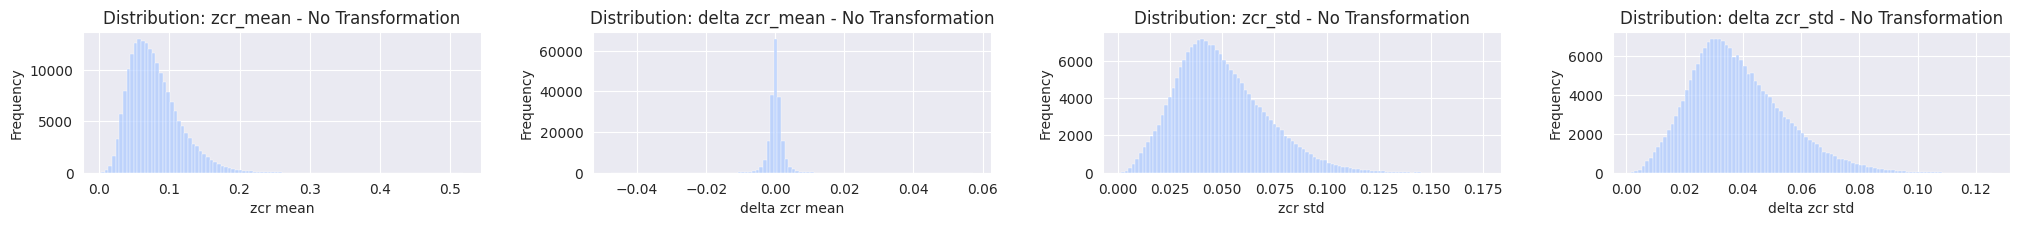

In [68]:
plot_multiple_distributions(zcr_data, n_rows = 1, n_cols = 4, size_inches = (20, 2), color = palette[1], state = "No Transformation")

#### Key Findings:


1. Generally, those are some pretty good looking distributions.

2. Except for the delta zcr_mean, the other three zero cross rate features are slightly right skewed, therefore they would benefit from a log-transformation.

<br>

Let's "zoom" into zcr_mean separately before concluding something:

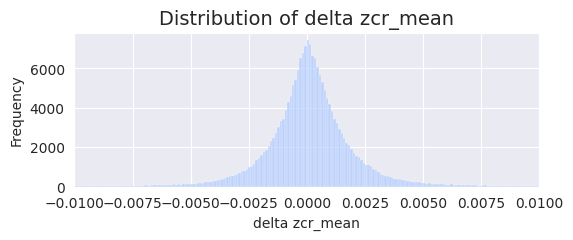

In [69]:
plt.figure(figsize = (6, 2))
plt.xlim(-0.01, 0.01)

sns.histplot(zcr_data["delta zcr_mean"], bins = 1000, color = palette[1])

plt.title("Distribution of delta zcr_mean", fontsize = 14)
plt.ylabel("Frequency", fontsize = 10)

plt.show()

- This distribution looks really normal.

<br>

Next, let's have a look how the distributions will look after log-transformation:

In [70]:
zcr_data_log = zcr_data.apply(lambda x: np.log1p(x))

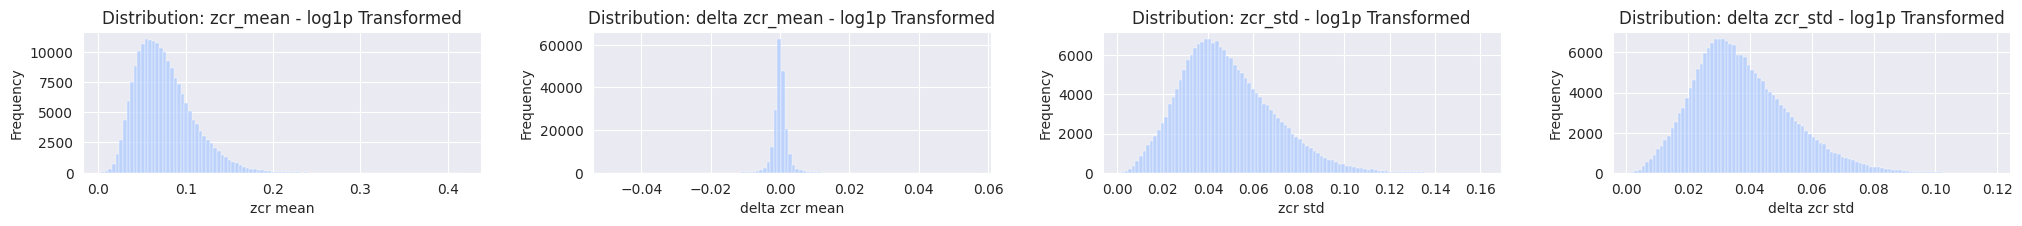

In [71]:
plot_multiple_distributions(zcr_data_log, n_rows = 1, n_cols = 4, size_inches = (20, 2), color = palette[1], state = "log1p Transformed")

If we look closely, the log_transformation reduced the tails of "zcr_mean", "zcr_std" and delta "zcr_std". Not too much, but it definitely dealed with some of the most extreme outliers.

- We can assume that log-transformation will be benefitial for our zcr features.

<br>

Let's continue with the exploration of all the "energy" related features.

In [72]:
energy_columns = [column for column in final_data.columns if "energy" in column]

In [73]:
energy_data = final_data[energy_columns]

In [74]:
len(energy_data.columns)

8

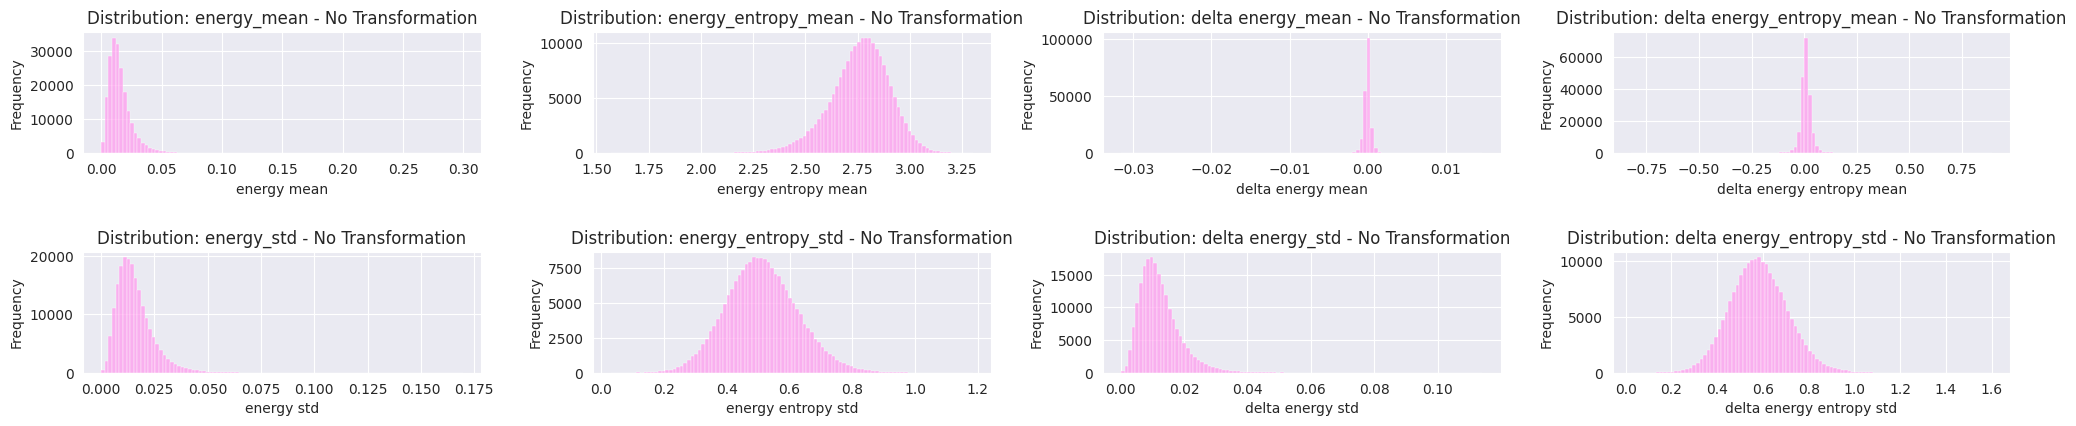

In [75]:
plot_multiple_distributions(energy_data, n_rows = 2, n_cols = 4, size_inches = (20, 4), color = palette[2], state = "No Transformation")

The situation is quite similar, we see only nice unimodal distributions, with some positive skewness and some very normal ones as well.

- Therefore we can apply log1p-transformation here as well and observe the results:

In [76]:
energy_data_log = energy_data.apply(lambda x: np.log1p(x))

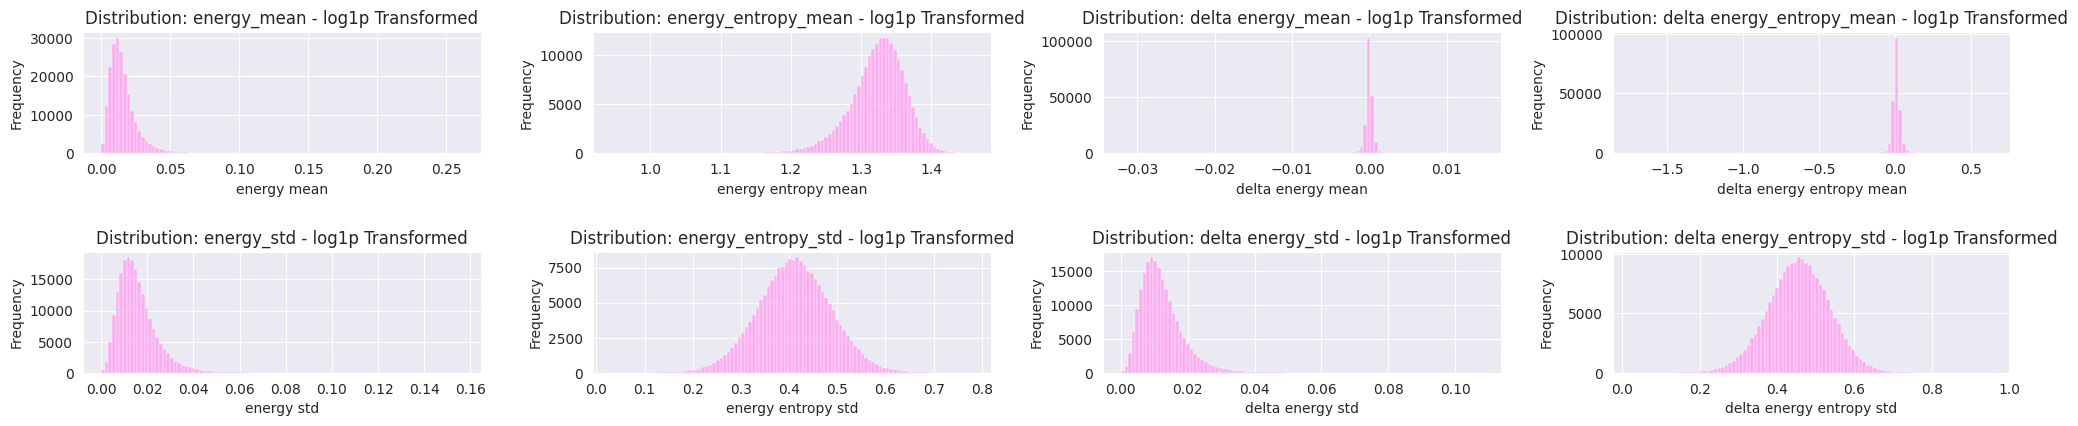

In [77]:
plot_multiple_distributions(energy_data_log, n_rows = 2, n_cols = 4, size_inches = (20, 4), color = palette[2], state = "log1p Transformed")

We can see that the log1p-transformation affects the distributions that are closest to normal the best, (energy_entropy_std e.g.), the rest are slightly affected and the tails get reduced a little.

- But, a little might be a lot for our model, we hope :)

<br>

We can now continue with the spectral features:

In [78]:
spectral_columns = [column for column in final_data.columns if "spectral" in column]

In [79]:
spectral_data = final_data[spectral_columns]

In [80]:
len(spectral_data.columns)

20

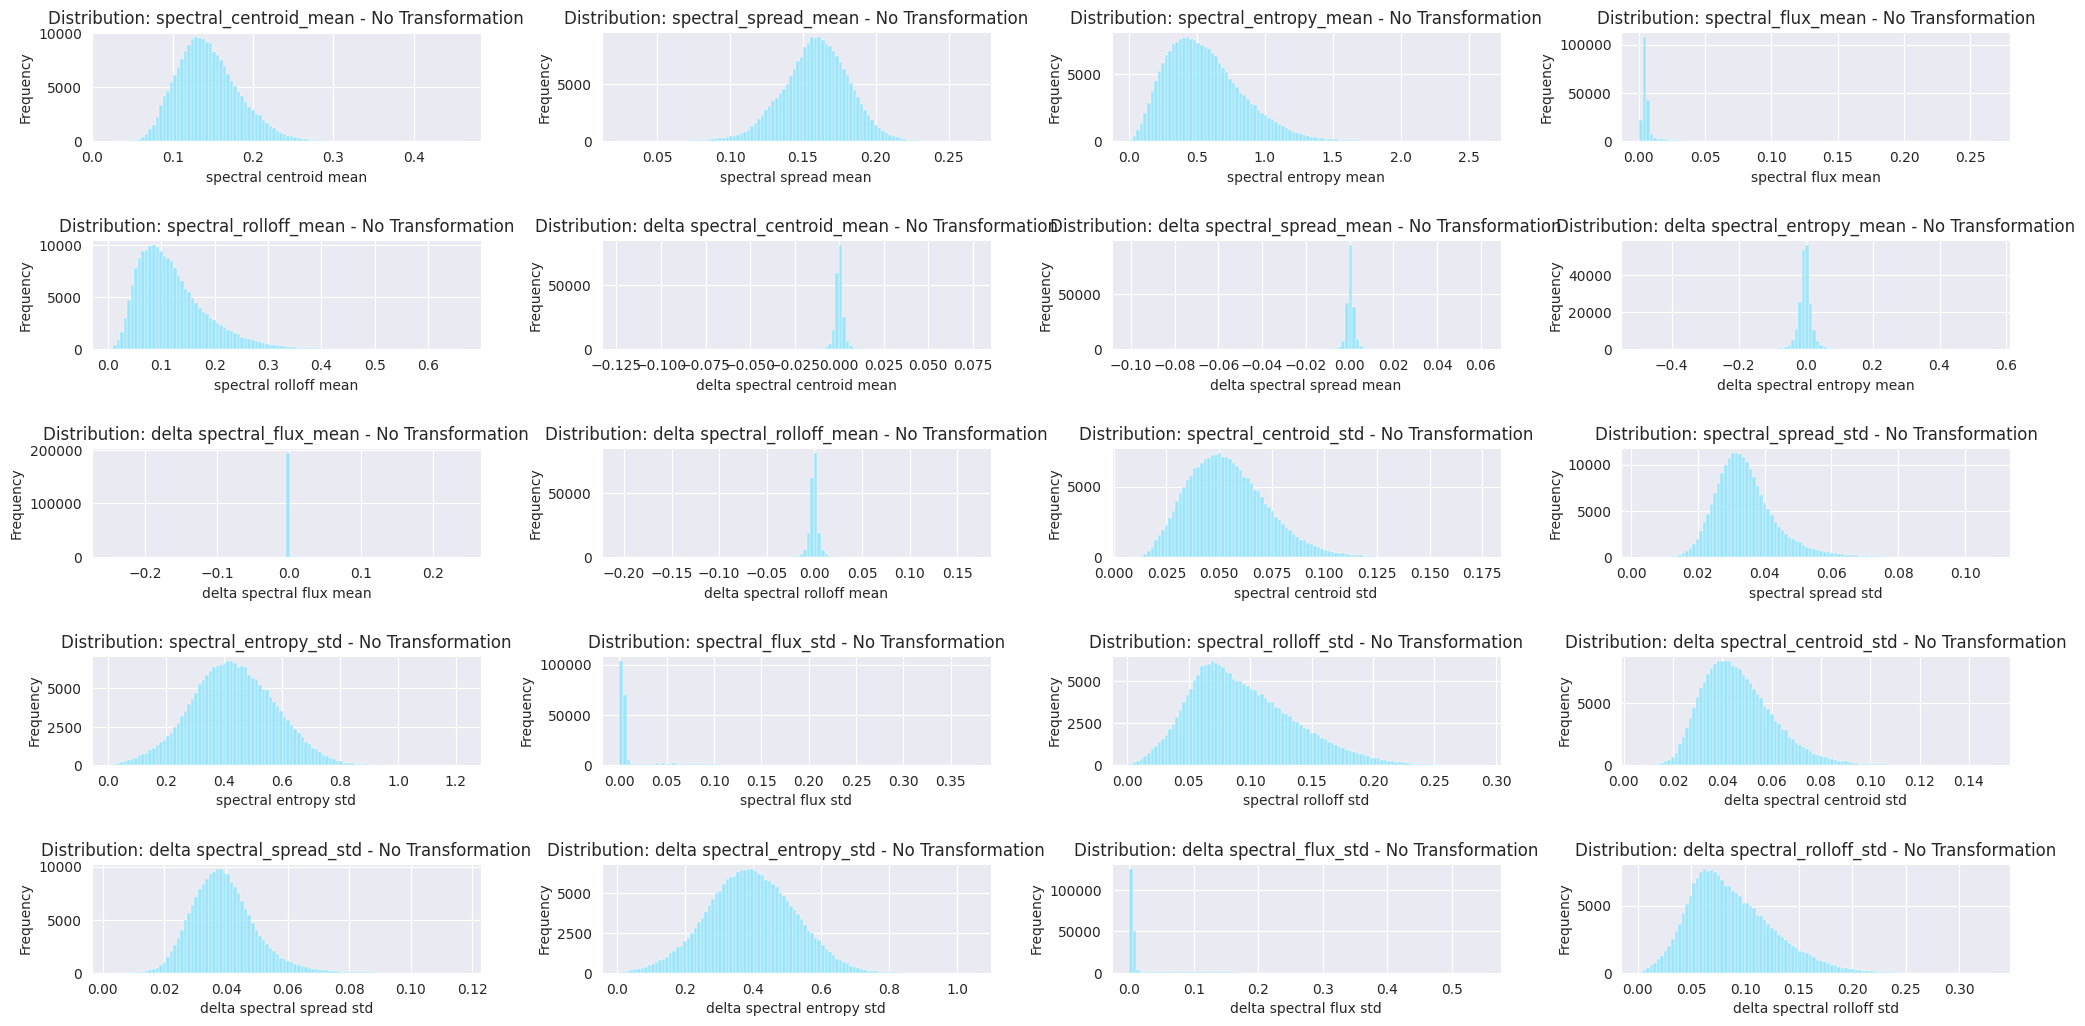

In [81]:
plot_multiple_distributions(spectral_data, n_rows = 5, n_cols = 4, size_inches = (20, 10), color = palette[4], state = "No Transformation")

So... The distributions here are a bit different, besides the common positively skewed and nearly normal ones, we have some that are hard to describe. Let's "zoom" into one of them and see how does it look in more detail:

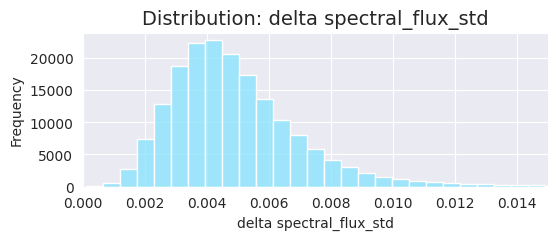

In [82]:
plt.figure(figsize = (6, 2))
plt.xlim(0, 0.015)

sns.histplot(spectral_data["delta spectral_flux_std"], bins = 1000, color = palette[4])

plt.title("Distribution: delta spectral_flux_std", fontsize = 14)
plt.ylabel("Frequency", fontsize = 10)

plt.show()

Well, hello there!

We might not need to worry much about our distributions, after all... Let's transform and observe.

In [83]:
spectral_data_log = spectral_data.apply(lambda x: np.log1p(x))

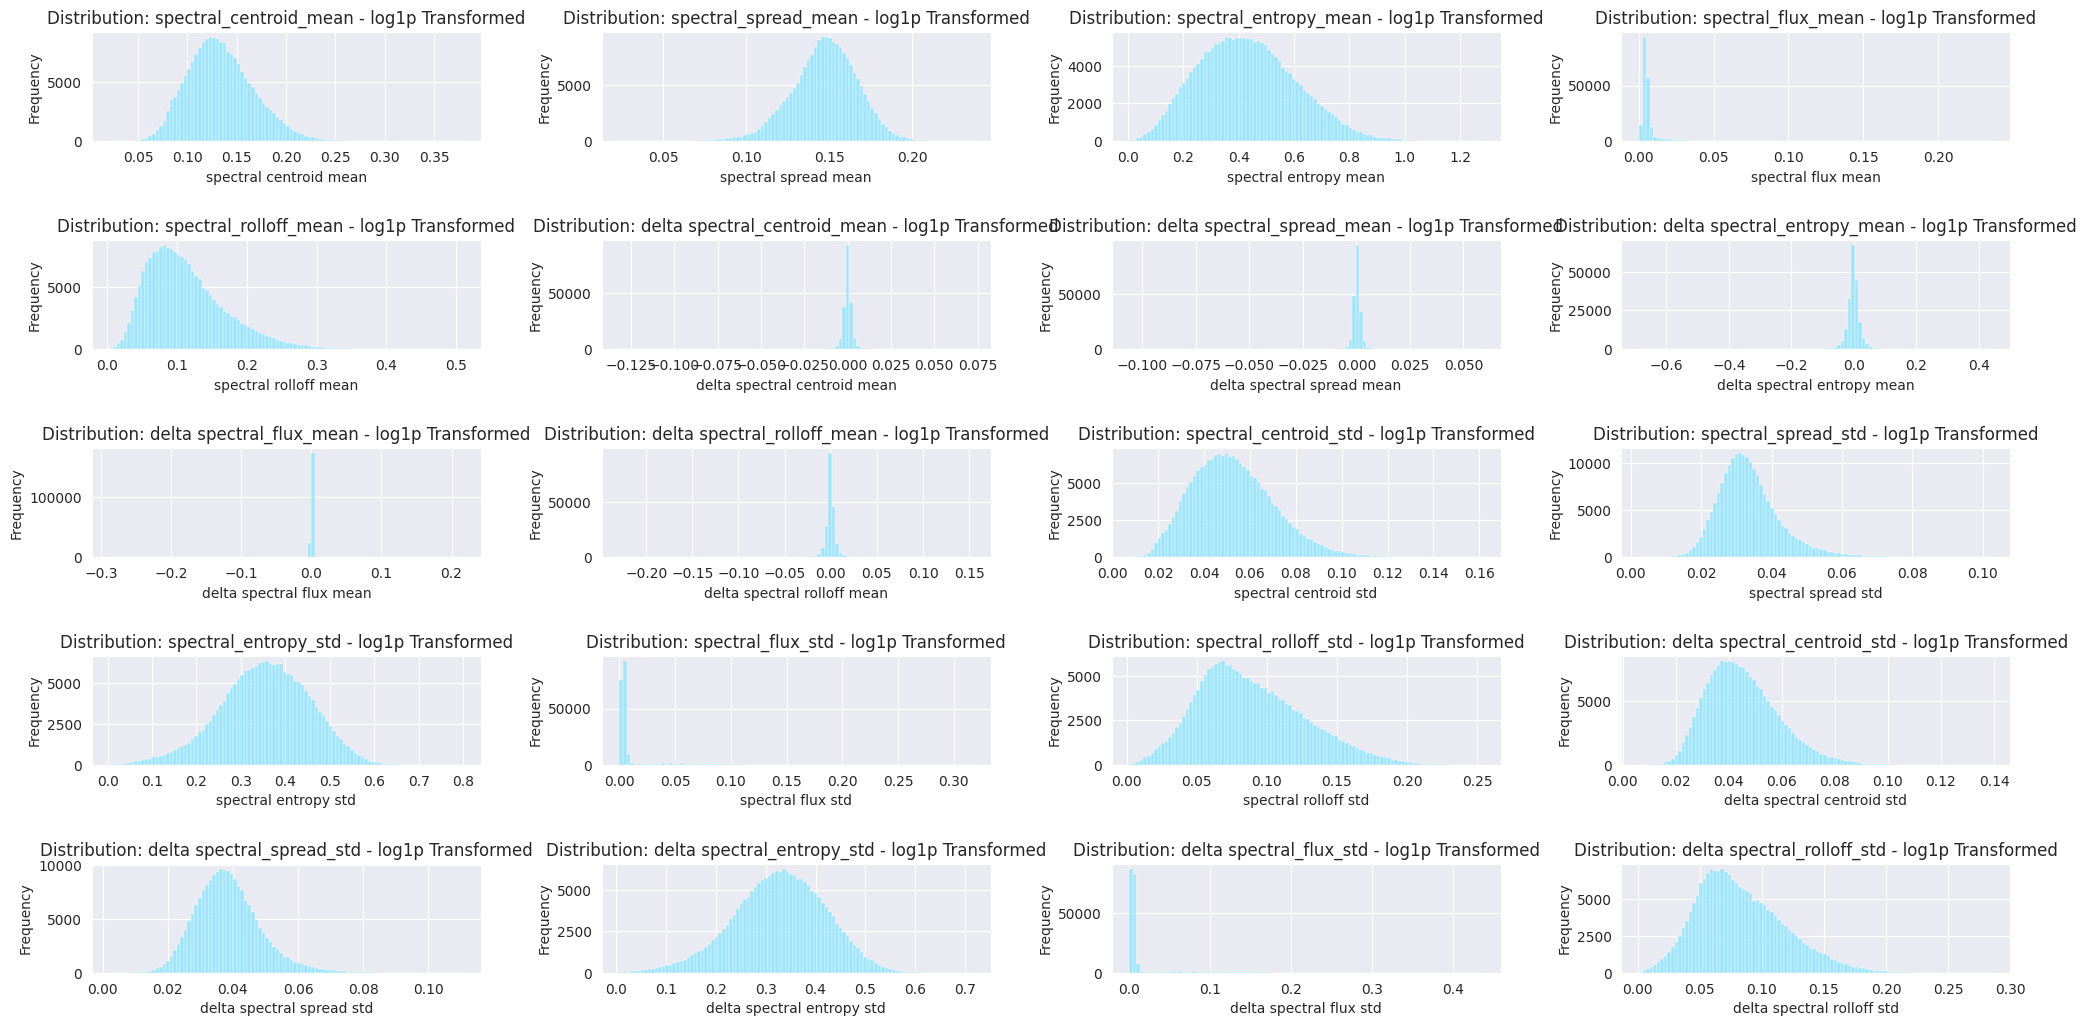

In [84]:
plot_multiple_distributions(spectral_data_log, n_rows = 5, n_cols = 4, size_inches = (20, 10), color = palette[4], state = "log1p Transformed")

The tails have been affected same fashion as before... we can conclude that log1p-transformation will have the same effect if the distributions are of the same kinds.

Continuing with the MFCC features.

In [85]:
mfcc_columns = [column for column in final_data.columns if "mfcc" in column]

In [86]:
mfcc_data = final_data[mfcc_columns]

In [87]:
len(mfcc_data.columns)

52

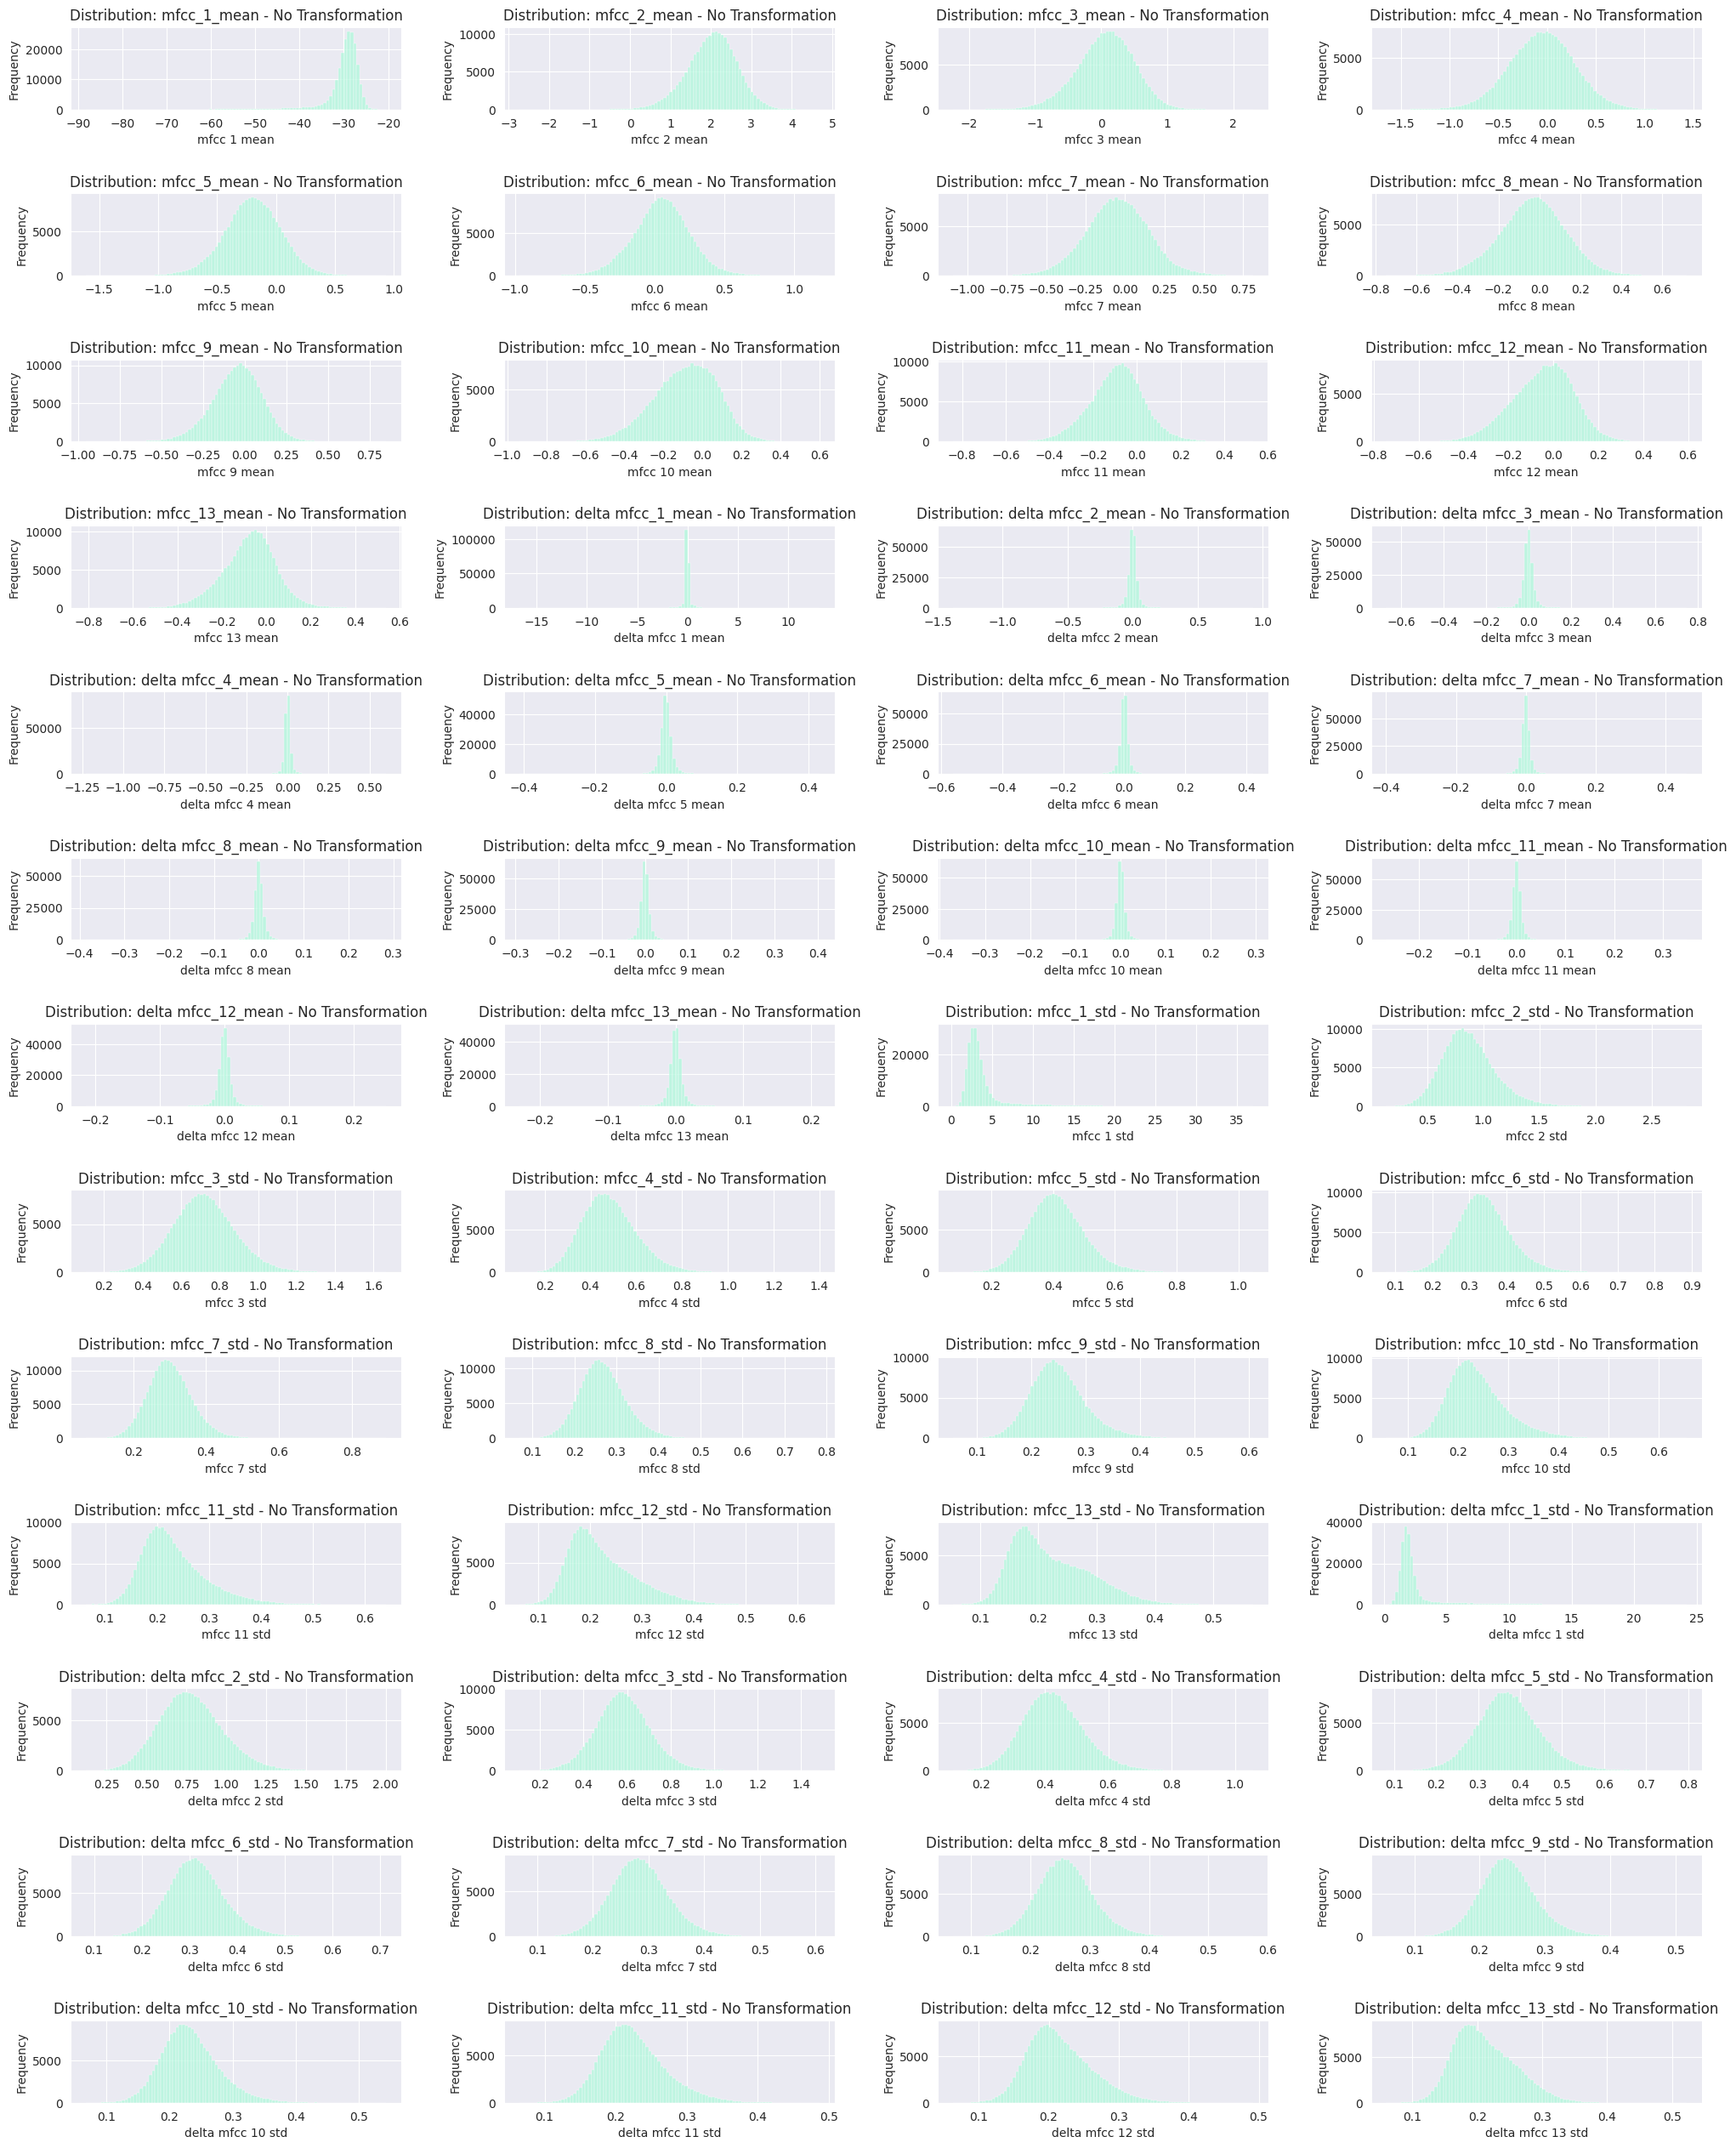

In [88]:
plot_multiple_distributions(mfcc_data, n_rows = 13, n_cols = 4, size_inches = (20, 25), color = palette[6], state = "No Transformation")

- Same types of distributions. All good!

<br>

Finally, let's explore the "chroma" features:

In [89]:
chroma_columns = [column for column in final_data.columns if "chroma" in column]

In [90]:
chroma_data = final_data[chroma_columns]

In [91]:
len(chroma_data.columns)

52

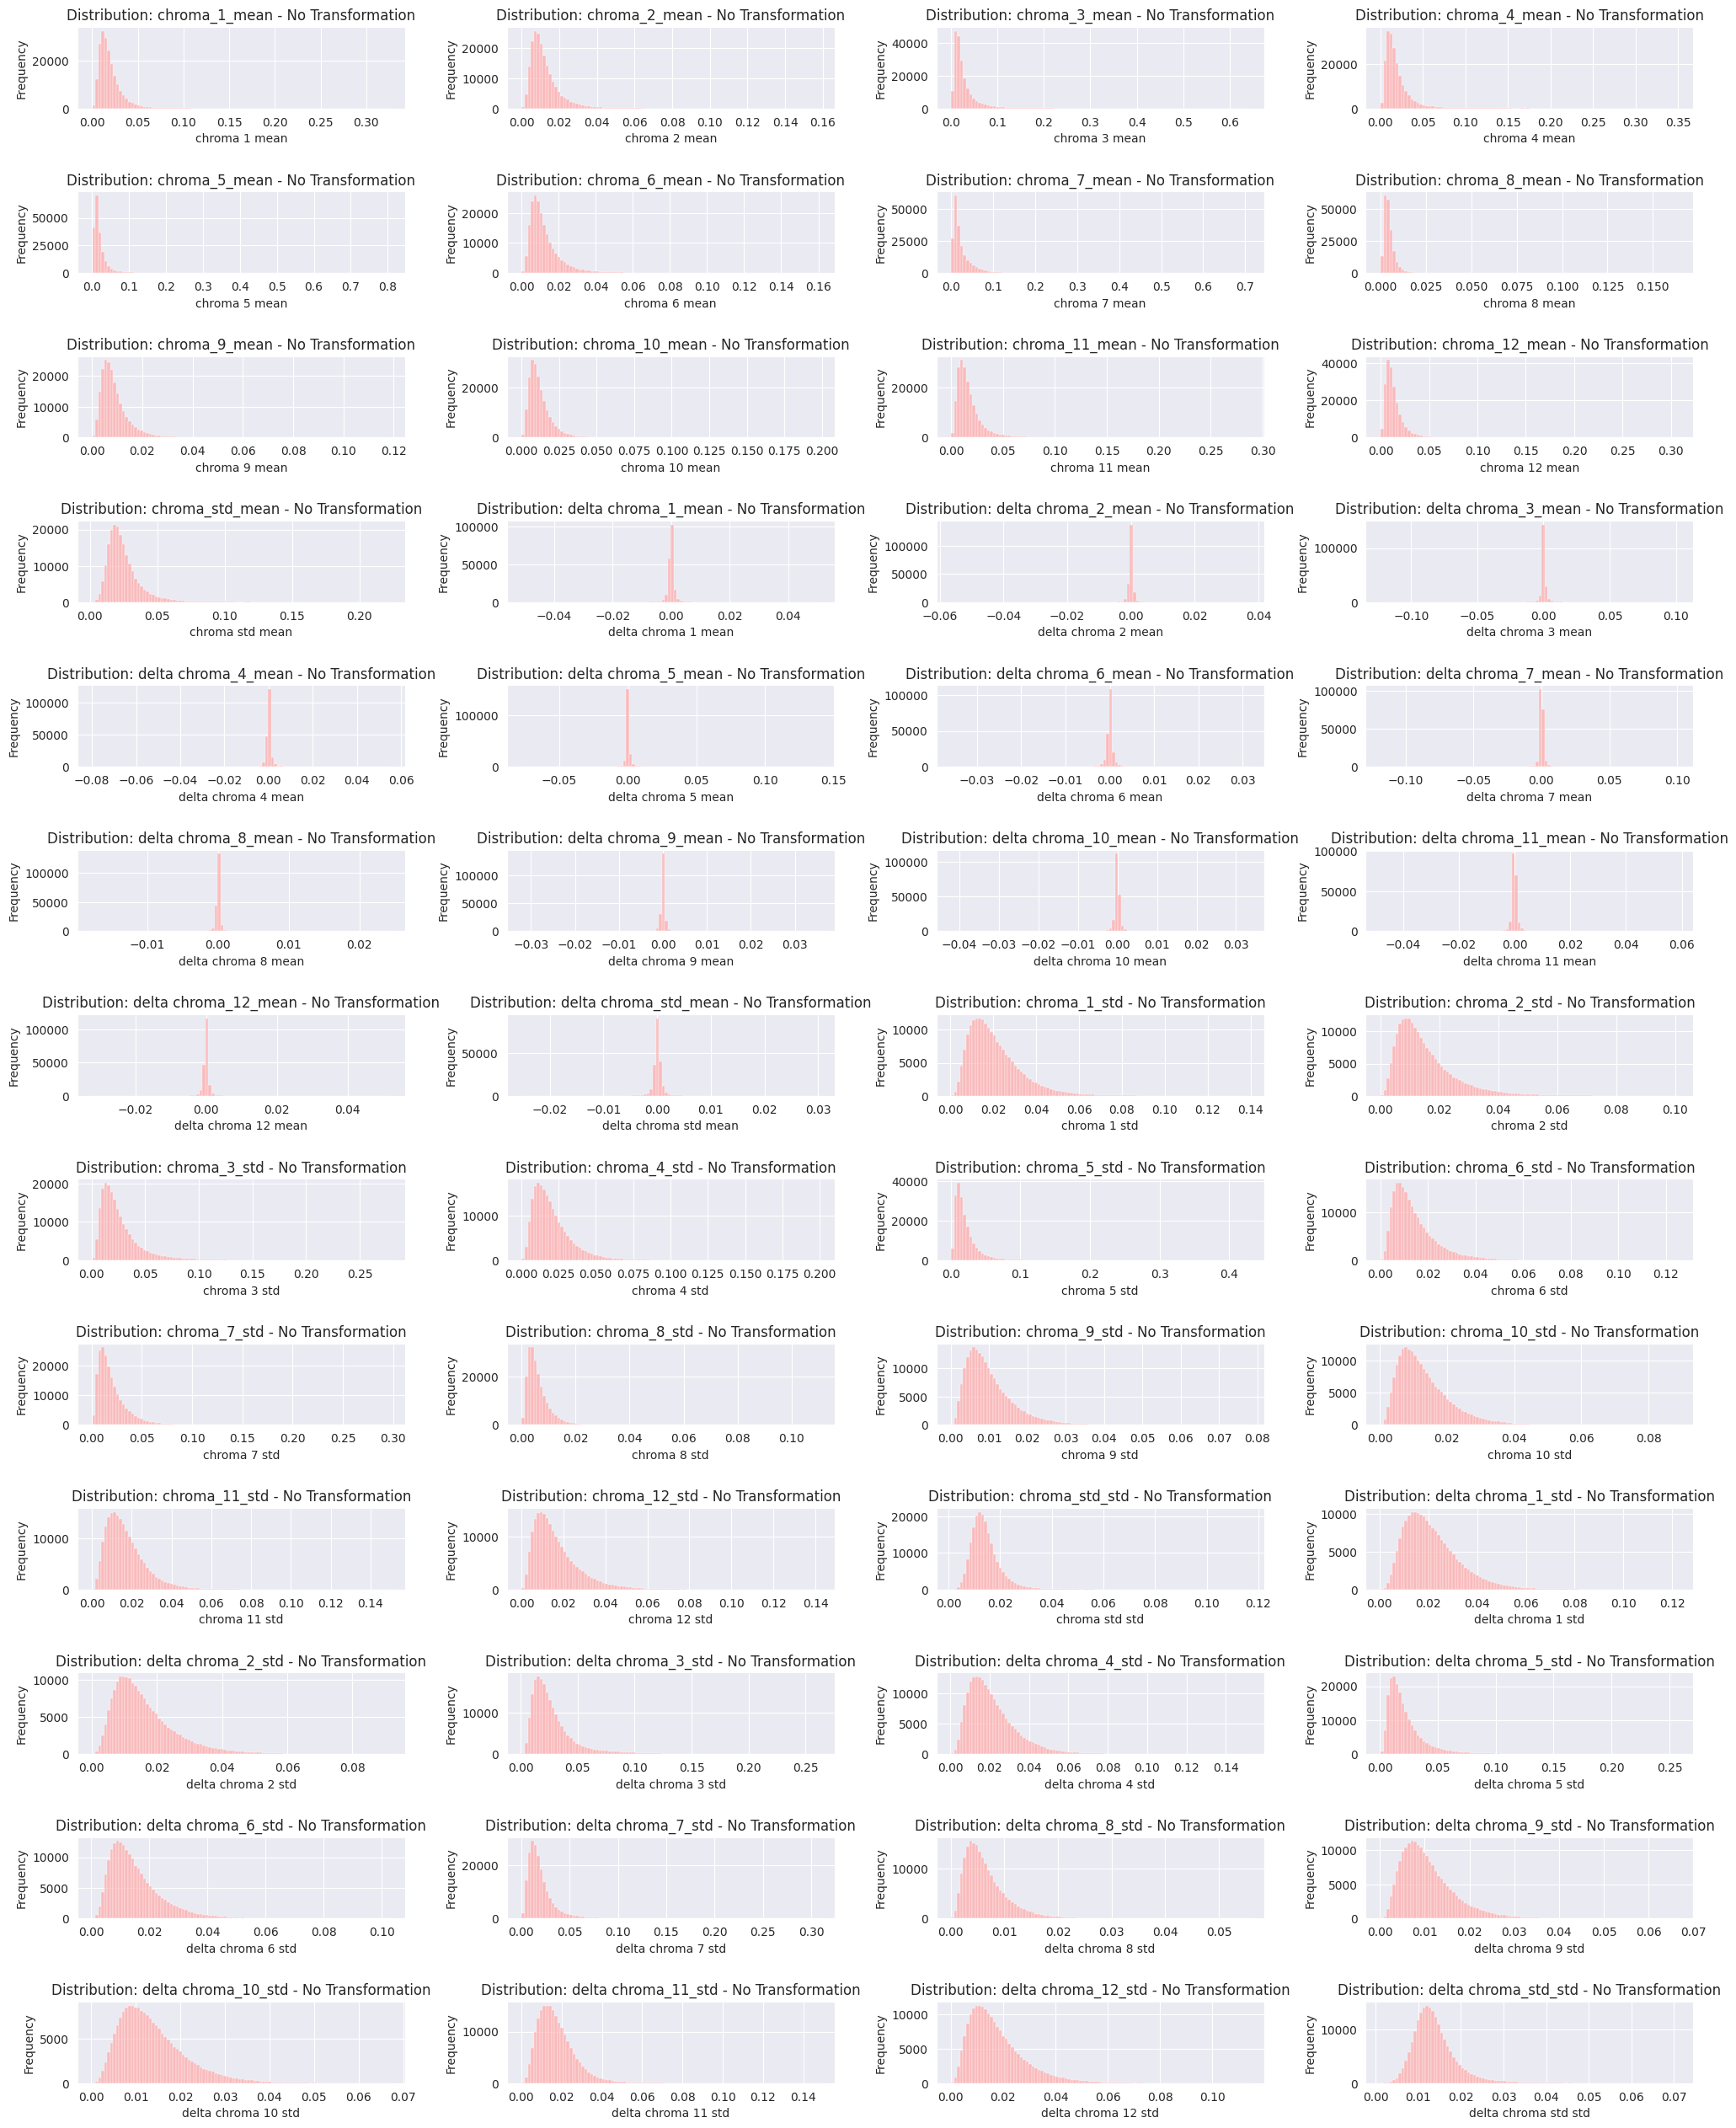

In [92]:
plot_multiple_distributions(chroma_data, n_rows = 13, n_cols = 4, size_inches = (20, 25), color = palette[10], state = "No Transformation")

We can do much more exploration of our features, and check in more detail about the outliers as well, but given the amount of features, we will try to keep things simple for this project.

As a last step, let's log1p-transform the whole dataset and save it to a new .csv file, so we can later compare the results.

<br>

**Note**: After dealing with a NaN error in the next section, we can discover that some of the columns turned into NaN's after log1p-transformation. Why is that?

- "For real-valued input data types, log1p always returns real output. For each value that cannot be expressed as a real number or infinity, it yields nan and sets the invalid floating point error flag." - this is out of the numpy documentation and explains what happened.


- That's why we will skip those columns and avoid transforming them, together with our target variable - gender.

In [93]:
cols_to_skip = [
    "gender",
    "mfcc_1_mean", 
    "mfcc_2_mean",
    "mfcc_3_mean",
    "mfcc_4_mean",
    "mfcc_5_mean",
    "mfcc_7_mean",
    "delta mfcc_1_mean",
    "delta mfcc_2_mean",
    "delta mfcc_4_mean"
]

In [94]:
# final_data.apply(lambda x: np.log1p(x) if x.name not in cols_to_skip else x).to_csv("final_data_transformed.csv", index = None)

In [95]:
final_data_transformed = pd.read_csv("final_data_transformed.csv")

In [96]:
final_data_transformed.columns[final_data_transformed.isna().any()].tolist()

[]

In [97]:
ipd.display(final_data.head(1), final_data_transformed.head(1))

gender  zcr_mean  energy_mean  energy_entropy_mean  spectral_centroid_mean  \
0       1  0.117871     0.020434             2.836491                0.187571   

   spectral_spread_mean  spectral_entropy_mean  spectral_flux_mean  \
0              0.165052               0.892865            0.003531   

   spectral_rolloff_mean  mfcc_1_mean  ...  delta chroma_4_std  \
0               0.201481   -26.286672  ...            0.020832   

   delta chroma_5_std  delta chroma_6_std  delta chroma_7_std  \
0            0.037702            0.025074            0.012432   

   delta chroma_8_std  delta chroma_9_std  delta chroma_10_std  \
0            0.006044            0.008054             0.013308   

   delta chroma_11_std  delta chroma_12_std  delta chroma_std_std  
0             0.018852             0.006251               0.01028  

[1 rows x 137 columns]

gender  zcr_mean  energy_mean  energy_entropy_mean  spectral_centroid_mean  \
0       1  0.111426     0.020228             1.344558                 0.17191   

   spectral_spread_mean  spectral_entropy_mean  spectral_flux_mean  \
0              0.152765               0.638091            0.003525   

   spectral_rolloff_mean  mfcc_1_mean  ...  delta chroma_4_std  \
0               0.183555   -26.286672  ...            0.020618   

   delta chroma_5_std  delta chroma_6_std  delta chroma_7_std  \
0            0.037008            0.024764            0.012356   

   delta chroma_8_std  delta chroma_9_std  delta chroma_10_std  \
0            0.006026            0.008021              0.01322   

   delta chroma_11_std  delta chroma_12_std  delta chroma_std_std  
0             0.018676             0.006232              0.010227  

[1 rows x 137 columns]

We see that the values have been transformed successfully, this time with no NaN's generated.

<br>

It is time for the next step!

## 6. Baseline Tests

In this section, we will three different models to observe the performance of each. Our dataset is of a decent size, so we can test some models that are known for good results and fast speed, when working with large datasets:

- [**LGBM Classifier**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) -  a gradient boosting framework that uses tree based learning algorithm.


- [**CatBoost Classifier**](https://catboost.ai/) - in CatBoost, symmetric trees, or balanced trees, refer to the splitting condition being consistent across all nodes at the same depth of the tree. LightGBM, on the other hand, results in asymmetric trees, meaning splitting condition for each node across the same depth can differ.


- [**XGBoost Classifier**](https://xgboost.readthedocs.io/en/stable/) -  it implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way.


<br>

It will be useful to observe how each of the baseline models perform to use as a reference.

We will set the number of iterations to 100, and use GPU for training, to speed up the models significantly.

<br>


In [98]:
def baseline_scores_with_scaling(data, target, models, model_names):
    label = data[target]
    features = data.drop(columns = [target], axis = 1)
    
    scaler = MinMaxScaler()
    scaler.fit_transform(features)

    X_train, X_test, y_train, y_test = train_test_split(
        features, 
        label, 
        test_size = 5000, 
        shuffle = True, 
    )
    
    df_results = pd.DataFrame(
        columns = [
            "model_name",
            "train_accuracy", 
            "test_accuracy",
            "test_f1",
            "test_roc_auc", 
            "test_log_loss",
            "fit_time",
            "score_time"
        ]
    )
    
    scoring = ["accuracy", "f1", "roc_auc"]
    
    for algo, name in zip(models, model_names):
        scores = cross_validate(
            algo, X_train, y_train, cv = 5, scoring = scoring, return_train_score = True
        )
        
        algo.fit(X_train, y_train)
        pred = algo.predict_proba(X_test)
        neg_log_loss = log_loss(y_test, pred)
        
        df_results.loc[name] = [
            name, 
            np.mean(scores["train_accuracy"]),
            np.mean(scores["test_accuracy"]),
            np.mean(scores["test_f1"]),
            np.mean(scores["test_roc_auc"]),
            np.mean(neg_log_loss),
            np.mean(scores["fit_time"]), 
            np.mean(scores["score_time"])
        ]
        
        del algo

    return df_results

In [99]:
models = [
    LGBMClassifier(
        objective = "binary",
        n_estimators = 100,
        verbose = 0,
        force_col_wise = True
    ),
    
    CatBoostClassifier(
        n_estimators = 100,
        verbose = 0,
#         task_type = "GPU"
    ),
    
    XGBClassifier(
        objective = "binary:logistic",
        eval_metric = "logloss",
#         predictor = "gpu_predictor",
#         tree_method = "gpu_hist",
        n_estimators = 100,
    )
]

In [100]:
model_names = [i.__class__.__name__ for i in models]

In [101]:
# baseline_results = baseline_scores_with_scaling(
#     data = final_data_transformed,
#     target = "gender",
#     models = models,
#     model_names = model_names
# )

In [102]:
# baseline_results.to_csv("baseline_results.csv", index = False)

In [103]:
baseline_results = pd.read_csv("baseline_results.csv")

In [104]:
baseline_results.sort_values("test_log_loss")

model_name  train_accuracy  test_accuracy   test_f1  test_roc_auc  \
2       XGBClassifier        0.971204       0.940395  0.940709      0.983300   
0      LGBMClassifier        0.941113       0.932303  0.932804      0.979421   
1  CatBoostClassifier        0.937963       0.932938  0.933324      0.978586   

   test_log_loss  fit_time  score_time  
2       0.154495  0.616512    0.063510  
0       0.174607  3.290617    0.071000  
1       0.178798  0.606115    0.022384

### 6. 1 Baseline Evaluation

Allright! Those are some pretty good results (at first sight). Compared with the previous research that this project was inspired by (where the accuracy of the models was around 0.50), those results feel pretty motivating.

- All the models give us good results, but in therms of log_loss, LGBM is doing better.


- LGBM and XGBoost show greater signs of overfitting the train data compared to the rest.


- Of course, we cannot be certain if our models are so good, we will need to go through some more steps of evaluation.

    - Let's define a few useful functions that will help us detect errors in our models:

In [105]:
def plot_confusion(model, data, target, img_name):
    
    features, label = data.drop(columns = target, axis = 1), data.gender
    
    scaler = MinMaxScaler()
    scaler.fit_transform(features)

    X_train, X_test, y_train, y_test = train_test_split(
        features, 
        label, 
        test_size = 5000, 
        shuffle = True, 
    )
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred)
    cm_flat = cm.flatten()

    true_pos = cm_flat[0]
    false_pos = cm_flat[1]
    false_neg = cm_flat[2]
    truen_neg = cm_flat[3]
    
    group_counts = [str(value) for value in cm_flat]
    f, ax = plt.subplots(figsize = (5, 4))

    group_names = ["True Negative","False Positive","False Negative","True Positive"]
    labels = [v1 + "\n" + v2 for v1, v2 in zip(group_names, group_counts)]
    labels = np.asarray(labels).reshape(2, 2)

    sns.heatmap(cm, annot = labels, fmt = "", ax = ax, cmap = colors)

    plt.title("Confusion Matrix of " + model.__class__.__name__)
    plt.xlabel("Prediction")
    plt.ylabel("True")
    
    plt.savefig(img_name)

    plt.show()

In [106]:
def plot_roc_curve(model, data, target, img_name):
    
    features, label = data.drop(columns = target, axis = 1), data.gender

    
    scaler = MinMaxScaler()
    scaler.fit_transform(features)

    X_train, X_test, y_train, y_test = train_test_split(
        features, 
        label, 
        test_size = 5000, 
        shuffle = True, 
    )
    
    ns_probs = [0 for _ in range(len(y_test))]

    model.fit(X_train, y_train)
    
    lr_probs = model.predict_proba(X_test)
    lr_probs = lr_probs[:, 1]

    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)

    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

    plt.plot(ns_fpr, ns_tpr, linestyle = "--", label = "No Skill")
    plt.plot(lr_fpr, lr_tpr, marker = ".", label = model.__class__.__name__)

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

    plt.legend()
    plt.savefig(img_name)

    plt.show()

In [107]:
def plot_log_loss_learning_curve(data, target, model, img_name, title_end, pca = False):
    
    features, label = data.drop(columns = target, axis = 1), data.gender
    
    scaler = MinMaxScaler()
    scaler.fit_transform(features)
    
    if pca == True:
        dim_reduction = PCA(n_components = 18)
        features = dim_reduction.fit_transform(features)
        
    X_train, X_test, y_train, y_test = train_test_split(
        features, 
        label, 
        test_size = 5000, 
        shuffle = True, 
        stratify = label
    )
    
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)
    
    train_sizes, train_scores, test_scores = learning_curve(
                                                estimator = model,
                                                X = X_train,
                                                y = y_train,
                                                train_sizes = np.linspace(0.1, 1.0, 10),
                                                cv = 10,
                                                n_jobs = -1,
                                                random_state = 42,
                                                scoring = "neg_log_loss"
                                            )

    # Mean value of accuracy against training data
    train_mean = np.mean(np.abs(train_scores), axis = 1)

    # Standard deviation of training accuracy per number of training samples
    train_std = np.std(np.abs(train_scores), axis = 1)

    # Same as above for test data
    test_mean = np.mean(np.abs(test_scores), axis = 1)
    test_std = np.std(np.abs(test_scores), axis = 1)
    
    plt.figure(figsize = (6, 4))

    plt.plot(train_sizes, train_mean, color = m_color, marker = "o", label = "Train")
    plt.fill_between(
        train_sizes,
        train_mean + train_std,
        train_mean - train_std,
        alpha = 0.15, color = m_color
    )

    plt.plot(train_sizes, test_mean, color = f_color, linestyle = "--", marker = "s", label = "Test")
    plt.fill_between(
        train_sizes,
        test_mean + test_std,
        test_mean - test_std,
        alpha = 0.15, color = f_color
    )
    
    plt.title(f"Learning Curve of {model.__class__.__name__} - {title_end}", fontsize = 12)
    plt.xlabel("Number of training samples", fontsize = 10)
    plt.ylabel("Missclassification Rate/Loss", fontsize = 10)
    
    plt.legend()
    plt.savefig(img_name)
    ax = plt.gca()
    ax.set_ylim([0, 1])
    
    plt.show()

In [108]:
def display_multiple_images(img_list, n_rows, n_cols, fig_size, title = False):
    images = [cv2.imread(image) for image in img_list]
    
    fig = plt.figure(figsize = fig_size)
    fig.subplots_adjust(wspace = 0, hspace = 0)
    
    for i in range(len(images)):

        ax = fig.add_subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i])
        
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect("equal")    

        plt.axis("off")
        if title == True:
            plt.title(" ".join("".join(img_list[i][:-4]).split("_")).title(), fontsize = 10)

Allright, we are ready for evaluation, let's first observe the confusion matrixes of all 3 models:

In [109]:
# plot_confusion(
#     model = models[0],
#     data = final_data_transformed,
#     target = "gender",
#     img_name = "conf_matrix_lgbm_data_transformed.png"
# )

# plot_confusion(
#     model = models[1],
#     data = final_data_transformed,
#     target = "gender",
#     img_name = "conf_matrix_catboost_data_transformed.png"
# )

# plot_confusion(
#     model = models[2],
#     data = final_data_transformed,
#     target = "gender",
#     img_name = "conf_matrix_xgboost_data_transformed.png"
# )

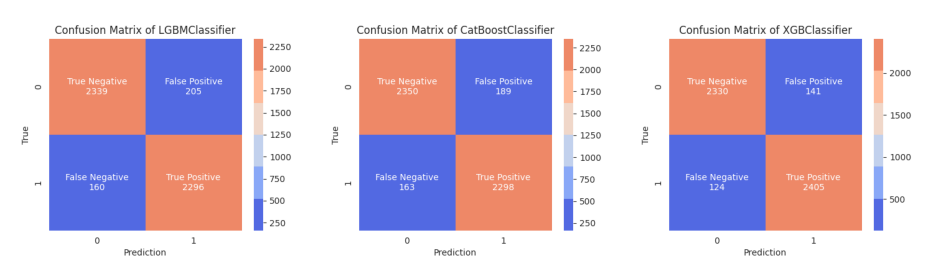

In [110]:
display_multiple_images(
    img_list = [
        "conf_matrix_lgbm_data_transformed.png",
        "conf_matrix_catboost_data_transformed.png",
        "conf_matrix_xgboost_data_transformed.png"
    ],
    n_rows = 1,
    n_cols = 3,
    fig_size = (12, 4),
)

It seems that our models handle the negative(female) class a bit better.

- Our data is almost perfectly balanced, which means that our features help the models predict the female voice slightly better than the male.

In [111]:
# plot_roc_curve(
#     model = models[0],
#     data = final_data_transformed,
#     target = "gender",
#     img_name = "roc_curve_lgbm_data_transformed.png"
# )

# plot_roc_curve(
#     model = models[1],
#     data = final_data_transformed,
#     target = "gender",
#     img_name = "roc_curve_catboost_data_transformed.png"
# )

# plot_roc_curve(
#     model = models[2],
#     data = final_data_transformed,
#     target = "gender",
#     img_name = "roc_curve_xgboost_data_transformed.png"
# )

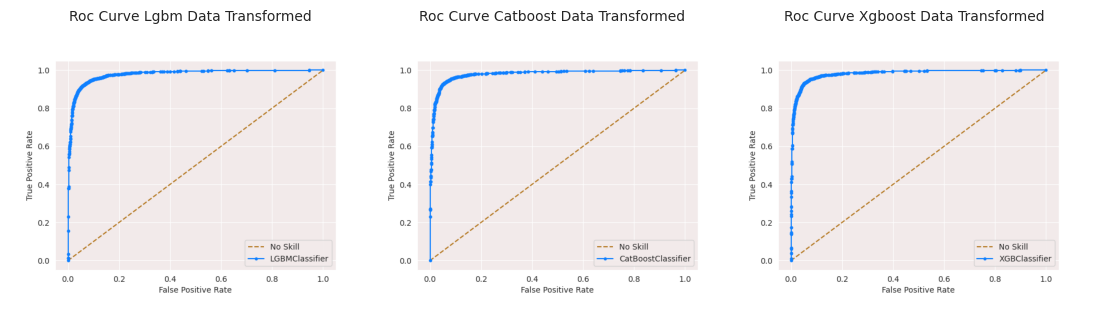

In [112]:
display_multiple_images(
    img_list = [
        "roc_curve_lgbm_data_transformed.png",
        "roc_curve_catboost_data_transformed.png",
        "roc_curve_xgboost_data_transformed.png"
    ],
    n_rows = 1,
    n_cols = 3,
    fig_size = (14, 6),
    title = True
)

The ROC curve shows the trade-off between sensitivity (or TPR) and specificity (1 – FPR). Classifiers that give curves closer to the top-left corner indicate a better performance.

- So we have good trade-off for all models, no visible difference.

In [113]:
# plot_log_loss_learning_curve(
#     data = final_data_transformed,
#     target = "gender",
#     model = models[0],
#     title_end = "Data Transformed",
#     img_name = "learning_curve_lgbm_data_transformed.png"
# )

# plot_log_loss_learning_curve(
#     data = final_data_transformed,
#     target = "gender",
#     model = models[1],
#     title_end = "Data Transformed",
#     img_name = "learning_curve_catboost_data_transformed.png"
# )

# plot_log_loss_learning_curve(
#     data = final_data_transformed,
#     target = "gender",
#     model = models[2],
#     title_end = "Data Transformed",
#     img_name = "learning_curve_xgboost_data_transformed.png"
# )


<br>

#### Let's discuss the next steps:

1. **Feature Selection** - we will use [shapley values](https://en.wikipedia.org/wiki/Shapley_value) and the SHAP library to evaluate the importance of our features, and the reduce them significantly increase model simplicity and reduce training resources.


2. **Dimensionality reduction** - To deal with overfitting: it reduces the model’s complexity and also removes some noise in the data. We will also reduce the issue with the multicolinearity problem in this way. **Note: We will only test PCA, not implement it, because it will create issues with the explainability of the model.**
    

3. **Model Tuning** - We will optimize the models by hyper-parameter tuning and cross-validation.


4. **Model Evaluation** - We will use different metrics to evaluate the performance of our models.

<br>

## 7. Feature Selection

Our goal is to reduce our features at least with to 30, while keeping the test accuracy over 0.9, log_loss under 0.30 and roc_auc score above 0.90.

In [114]:
 def extract_shap_values(data, target, algo, explainer_type):
    y = data[target]
    X = data.drop(columns = [target], axis = 1)
    
    scaler = MinMaxScaler()
    scaler.fit(X)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size = 5000, shuffle = True, random_state = 42
    )
    
    algo.fit(X_train, y_train)
    
    explainer = explainer_type(algo, X_test)
    shap_values = explainer(X_test)
    
    return shap_values

In [115]:
# lgbm_shap_values = extract_shap_values(
#     data = final_data_transformed,
#     target = "gender",
#     algo = models[0],
#     explainer_type = shap.TreeExplainer
# )

In [116]:
# shap.summary_plot(lgbm_shap_values, max_display = 20, plot_type = "bar", color = palette[1], plot_size = [6, 6], show = False)
# plt.savefig("lgbm_feature_importances.png", dpi = 1200)

In [117]:
# catboost_shap_values = extract_shap_values(
#     data = final_data_transformed,
#     target = "gender",
#     algo = models[1],
#     explainer_type = shap.TreeExplainer
# )

In [118]:
# shap.summary_plot(catboost_shap_values, max_display = 20, plot_type = "bar", color = palette[2], plot_size = [6, 6], show = False)
# plt.savefig("catboost_feature_importances.png", dpi = 1200)

In [119]:
# xgboost_shap_values = extract_shap_values(
#     data = final_data_transformed,
#     target = "gender",
#     algo = models[2],
#     explainer_type = shap.TreeExplainer
# )

In [120]:
# shap.summary_plot(xgboost_shap_values, max_display = 20, plot_type = "bar", color = palette[4], plot_size = [6, 6], show = False)
# plt.savefig("xgboost_feature_importances.png", dpi = 1200)

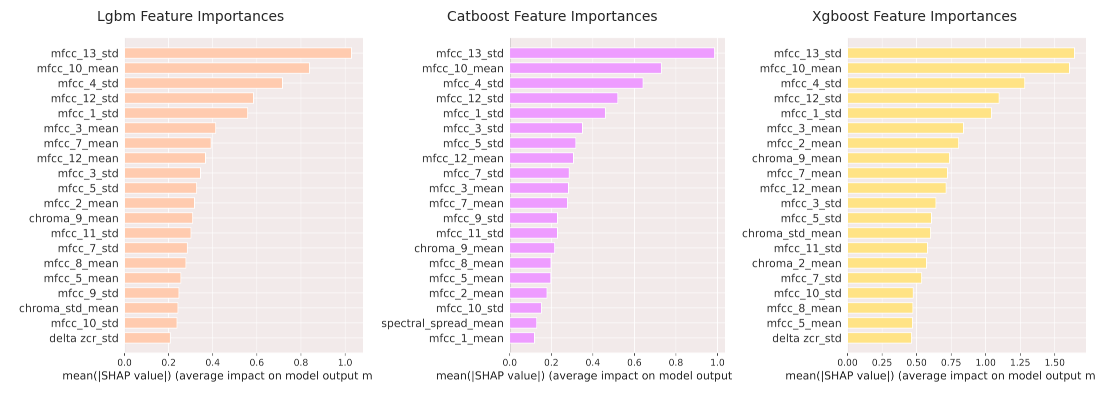

In [121]:
display_multiple_images(
    img_list = [
        "lgbm_feature_importances.png", 
        "catboost_feature_importances.png", 
        "xgboost_feature_importances.png"
    ],
    n_rows = 1,
    n_cols = 3,
    fig_size = (14, 6),
    title = True
)

In [122]:
cols_to_keep = [
    "mfcc_13_std", "mfcc_10_mean", "mfcc_4_std", "mfcc_12_std", "mfcc_12_mean", "mfcc_1_std", 
    "mfcc_3_mean", "mfcc_3_std", "mfcc_7_mean", "mfcc_7_std", "mfcc_9_std", "mfcc_5_std",
    "mfcc_2_mean", "mfcc_11_std", "mfcc_8_mean", "mfcc_5_mean","mfcc_10_std", "mfcc_1_mean",
    "chroma_9_mean", "chroma_std_mean", "chroma_2_mean", "delta zcr_std", "delta mfcc_2_std",
    "spectral_spread_mean","gender"
]

In [123]:
final_data_transformed_reduced = final_data_transformed[cols_to_keep]

In [124]:
final_data_transformed_reduced.shape

(200000, 25)

In [125]:
# final_data_transformed_reduced.to_csv("final_data_transformed_reduced.csv", index = False)

In [126]:
final_data_transformed_reduced = pd.read_csv("final_data_transformed_reduced.csv")

In [127]:
# baseline_results_data_reduced = baseline_scores_with_scaling(
#     data = final_data_transformed_reduced,
#     target = "gender",
#     models = models,
#     model_names = model_names,
# )

In [128]:
# baseline_results_data_reduced.to_csv("baseline_results_data_reduced.csv", index = False)

In [129]:
baseline_results_data_reduced = pd.read_csv("baseline_results_data_reduced.csv")

In [130]:
baseline_results_data_reduced.sort_values("test_log_loss").style.set_caption("Baseline Tests - Data Reduced")

In [131]:
# plot_confusion(
#     model = models[0],
#     data = final_data_transformed_reduced,
#     target = "gender",
#     img_name = "conf_matrix_lgbm_data_transformed_reduced.png"
# )

# plot_confusion(
#     model = models[1],
#     data = final_data_transformed_reduced,
#     target = "gender",
#     img_name = "conf_matrix_catboost_data_transformed_reduced.png"
# )

# plot_confusion(
#     model = models[2],
#     data = final_data_transformed_reduced,
#     target = "gender",
#     img_name = "conf_matrix_xgboost_data_transformed_reduced.png"
# )

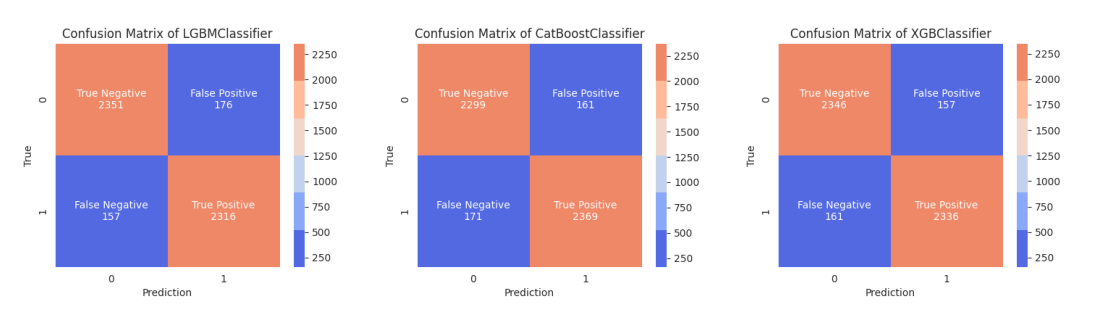

In [132]:
display_multiple_images(
    img_list = [
        "conf_matrix_lgbm_data_transformed_reduced.png",
        "conf_matrix_catboost_data_transformed_reduced.png",
        "conf_matrix_xgboost_data_transformed_reduced.png"
    ],
    n_rows = 1,
    n_cols = 3,
    fig_size = (14, 6)
)

Seems that when we reduced our features we reduced some noise in our data and now the models predict the classes in a more balanced way, still inclied a bit more towards the female class, but not as much for sure.

In [133]:
# plot_roc_curve(
#     model = models[0],
#     data = final_data_transformed_reduced,
#     target = "gender",
#     img_name = "roc_curve_lgbm_data_transformed_reduced.png"
# )

# plot_roc_curve(
#     model = models[1],
#     data = final_data_transformed_reduced,
#     target = "gender",
#     img_name = "roc_curve_catboost_data_transformed_reduced.png"
# )

# plot_roc_curve(
#     model = models[2],
#     data = final_data_transformed_reduced,
#     target = "gender",
#     img_name = "roc_curve_xgboost_data_transformed_reduced.png"
# )

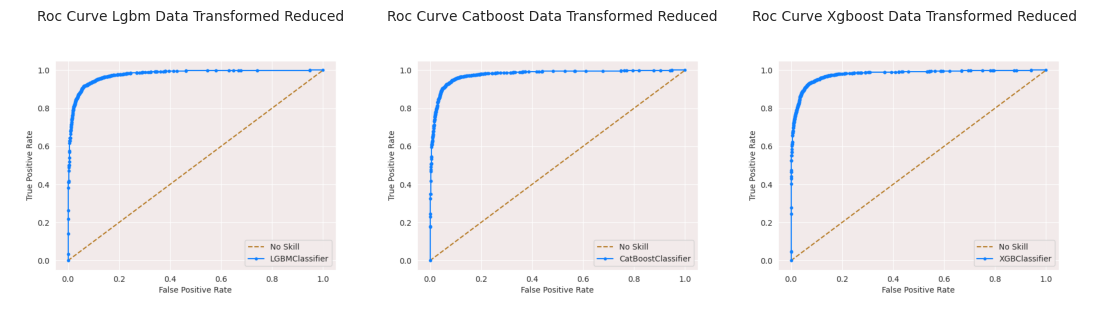

In [134]:
display_multiple_images(
    img_list = [
        "roc_curve_lgbm_data_transformed_reduced.png",
        "roc_curve_catboost_data_transformed_reduced.png",
        "roc_curve_xgboost_data_transformed_reduced.png"
    ],
    n_rows = 1,
    n_cols = 3,
    fig_size = (14, 6),
    title = True
)

No visible difference, still great curves for all models.

In [135]:
# plot_log_loss_learning_curve(
#     data = final_data_transformed_reduced,
#     target = "gender",
#     model = models[0],
#     title_end = "Data Reduced",
#     img_name = "learning_curve_lgbm_data_transformed_reduced.png"
# )

# plot_log_loss_learning_curve(
#     data = final_data_transformed_reduced,
#     target = "gender",
#     model = models[1],
#     title_end = "Data Reduced",
#     img_name = "learning_curve_catboost_data_transformed_reduced.png"
# )

# plot_log_loss_learning_curve(
#     data = final_data_transformed_reduced,
#     target = "gender",
#     model = models[2],
#     title_end = "Data Reduced",
#     img_name = "learning_curve_xgboost_data_transformed_reduced.png"
# )

## 8. Dimensionality Reduction

- We will use [**PCA**](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) - Linear dimensionality reduction using Singular Value Decomposition of the data to project it to a lower dimensional space. The input data is centered but not scaled for each feature before applying the SVD.

In [136]:
def calculate_variance_ratio(data, algo):
    audio_features, gender_label = data.drop(columns = "gender"), data.gender

    scaler = MinMaxScaler()
    features_scaled = scaler.fit_transform(audio_features)

    algo.fit(features_scaled, gender_label)

    return algo.explained_variance_ratio_


def plot_variance_ratio(ratio, title):
    plt.figure(figsize = (6, 4))
    plt.plot(np.cumsum(ratio), color = f_color)

    plt.axhline(linewidth = 2, color = m_color, linestyle = "--", y = 0.95, xmin = 0, xmax = 25)

    plt.xlabel("Number of components", fontsize = 10)
    plt.ylabel("Cumulative explained variance", fontsize = 10)
    plt.title(title, fontsize = 14)

    plt.show()

In [137]:
pca_ratio = calculate_variance_ratio(data = final_data_transformed_reduced, algo = PCA(n_components = 24))

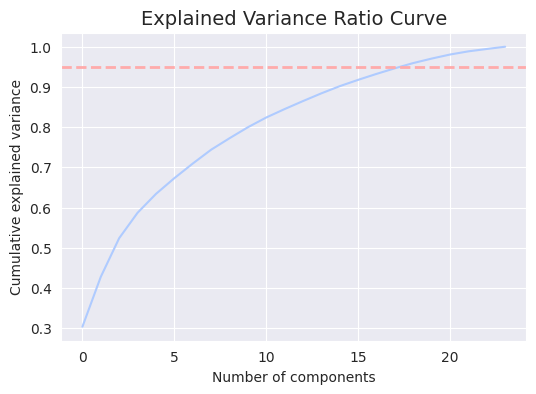

In [138]:
plot_variance_ratio(pca_ratio, title = "Explained Variance Ratio Curve")

#### Key Findings

1. Looking at the plot above, when we use PCA to transform our 136 predicting variables down to 17-18 components, we can still explain around 95-6% of the variance. That's quite impressive!


2. The other features we have, explain 5% of the variance. Using this logic, we will use PCA at n_components = 18, and test our models again.

In [139]:
def pca_test(data, target, models, model_names, components):    
    label = data[target]
    features = data.drop(columns = [target], axis = 1)
    
    scaler = MinMaxScaler()
    scaler.fit_transform(features)

    X_train, X_test, y_train, y_test = train_test_split(
        features, label, test_size = 5000, shuffle = True, 
    )
    
    df_results = pd.DataFrame(
        columns = [
            "model_name",
            "train_accuracy", 
            "test_accuracy",
            "test_f1",
            "test_roc_auc", 
            "test_log_loss",
            "fit_time",
            "score_time"
        ]
    )
    
    scoring = ["accuracy", "f1", "roc_auc"]
    
    for algo, name in zip(models, model_names):
        
        pipeline = Pipeline([
            ("dim_reduction", PCA(n_components = components)),
            ("classifier", algo)
        ])
        
        scores = cross_validate(pipeline, X_train, y_train, cv = 5, scoring = scoring, return_train_score = True)

        pipeline.fit(X_train, y_train)
        pred = pipeline.predict_proba(X_test)
        neg_log_loss = log_loss(y_test, pred)
        
        df_results.loc[name] = [
            name, 
            np.mean(scores["train_accuracy"]),
            np.mean(scores["test_accuracy"]),
            np.mean(scores["test_f1"]),
            np.mean(scores["test_roc_auc"]),
            np.mean(neg_log_loss),
            np.mean(scores["fit_time"]), 
            np.mean(scores["score_time"])
        ]
        
        del algo

    return df_results

In [140]:
# pca_test_results = pca_test(
#     data = final_data_transformed_reduced,
#     target = "gender",
#     models = models,
#     model_names = model_names,
#     components = 18
# )

In [141]:
# pca_test_results.to_csv("pca_test_results.csv", index = False)

In [142]:
pca_test_results = pd.read_csv("pca_test_results.csv")

In [143]:
pca_test_results.sort_values("test_log_loss").style.set_caption("PCA Dimensionality Reduction Test")

#### Key Findings:

The scores dropped, but not too badly:

1. XGBoost shows signs of overfitting even with PCA applied, but we will try to improve this.


2. Speed performance was improved greatly for all models.


- But... PCA worsened the scores for all models, why?  This is because, in general, applying PCA before building a model will NOT help to make the model perform better (in terms of accuracy)! This is because PCA is an algorithm that does not consider the response variable / prediction target into account. We will try to compensate that with optimization!


<br>

## 9. Model Optimization

Now that we've learned more about our features, it is time to optimize.

- We will be tuning our models using [Optuna](https://optuna.readthedocs.io/en/stable/) — a next-generation bayesian hyperparameter tuning framework. Optuna is an automatic hyperparameter optimization software framework, particularly designed for machine learning. It features an imperative, define-by-run style user API. Thanks to their define-by-run API, the code written with Optuna enjoys high modularity, and the user of Optuna can dynamically construct the search spaces for the hyperparameters.

The optimization process in Optuna requires a function called **objective** that:

1. Includes the parameter grid to search as a dictionary.
   

2. Creates a model to try hyperparameter combination sets.
   

3. Fits the model to the data with a single candidate set.
    

4. Generates predictions using this model.
   

5. Scores the predictions based on user-defined metrics and returns it.


<br>

So, now we will optimize all the models in therms of log_loss, this will be our main metric. Why? - The Log Loss metric takes into account the probabilities underlying your models, and not only the final output of the classification. 

- The bolder the probabilities, the better will be our Log Loss — closer to zero. It is a measure of uncertainty (we may call it entropy), so a low Log Loss means a low uncertainty/entropy of the model. Log Loss is similar to the Accuracy, but it will favor models that distinguish more strongly the classes. Log Loss is useful to compare models not only on their output but on their probabilistic outcome.

**Note:**

We will tune hyper-parameters that are known to make reduce the overfittin and improve the stability of the model. We are not going to discuss all hyper-parameters in detail, but briefly we will use them to:

1. Try different values for the learning_rate (Step size shrinkage) - used in update to prevents overfitting. After each boosting step, we can directly get the weights of new features, and the learning rate shrinks the feature weights to make the boosting process more conservative.


2. Reduce the maximum depth of a tree - decreasing this value will make the model less complex and more will reduce overfitting (we will try a range between 2 and 12).


3. Test different subsample ratios of the training instances - setting it to less than 1 it will mean that our algorithm would randomly sample a fraction of the training data prior to growing trees. and this will prevent overfitting.


4. Test L1 and/or L2 regularization terms on weights. Increasing this value will make the models more conservative.


5. Try different values for the minimum data in a leaf - important parameter to prevent over-fitting in a leaf-wise trees. Its optimal value depends on the number of training samples and num_leaves. Setting it to a large value can avoid growing too deep a tree, but may cause under-fitting. In practice, setting it to hundreds or thousands is enough for a large dataset.


And more...

#### So, let's begin by defining the first objective function for LGBM!

In [144]:
audio_features = final_data_transformed_reduced.drop(columns = "gender")
gender_label = final_data_transformed_reduced.gender

In [145]:
def lgbm_log_loss_objective(trial, X, y, splits):

    param_grid = {
        "classifier__n_estimators": trial.suggest_categorical("n_estimators", [100]),
        "classifier__learning_rate": trial.suggest_float("learning_rate", 0.01, 0.5),
        "classifier__num_leaves": trial.suggest_int("num_leaves", 20, 3000, step = 20),
        "classifier__max_depth": trial.suggest_int("max_depth", 2, 12),
        "classifier__min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step = 100),
        "classifier__lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step = 5),
        "classifier__lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step = 5),
        "classifier__min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "classifier__bagging_fraction": trial.suggest_float("bagging_fraction", 0.2, 0.95, step = 0.1),
        "classifier__bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "classifier__feature_fraction": trial.suggest_float("feature_fraction", 0.2, 0.95, step = 0.1),
        "classifier__early_stopping_roudns": trial.suggest_categorical("early_stopping_rounds", [100])
    }
    
    cv = KFold(n_splits = splits, shuffle = True, random_state = 42)
    cv_scores = np.empty(splits)

    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        pipeline = Pipeline([
            ("scaler", MinMaxScaler()),
            ("classifier", LGBMClassifier(
                objective = "binary", 
                eval_set = [(X_test, y_test)],
                n_jobs = -1,
                force_col_wise = True,
                eval_metric = "binary_logloss",
            ))
        ])
        pipeline.set_params(**param_grid)
        pipeline.fit(X_train, y_train)

        preds = pipeline.predict_proba(X_test)
        cv_scores[idx] = log_loss(y_test, preds)

    return np.mean(cv_scores)

In [146]:
# lgbm_log_loss_study = optuna.create_study(direction = "minimize", study_name = "LGBM log_loss Optimization")

# func = lambda trial: lgbm_log_loss_objective(
#     trial, 
#     X = audio_features, 
#     y = gender_label, 
#     splits = 5
# )

# lgbm_log_loss_study.optimize(func, n_trials = 200)

# joblib.dump(lgbm_log_loss_study, "lgbm_log_loss_study.pkl")

Using the slice plot of optuna, we can see the ranges of hyper-parameter values that gave the best results and create a second study in those ranges to further optimize our model in depth.

In [147]:
lgbm_study_1 = joblib.load("lgbm_log_loss_study.pkl")
fig = optuna.visualization.plot_slice(lgbm_study_1)
fig.show()

In [148]:
def lgbm_log_loss_objective_2(trial, X, y, splits):

    param_grid = {
        "classifier__n_estimators": trial.suggest_categorical("n_estimators", [100]),
        "classifier__learning_rate": trial.suggest_float("learning_rate", 0.3, 0.45),
        "classifier__num_leaves": trial.suggest_int("num_leaves", 1600, 2500, step = 20),
        "classifier__max_depth": trial.suggest_int("max_depth", 9, 11),
        "classifier__min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 100, 1500),
        "classifier__lambda_l1": trial.suggest_int("lambda_l1", 0.2, 10),
        "classifier__lambda_l2": trial.suggest_int("lambda_l2", 45, 50),
        "classifier__min_gain_to_split": trial.suggest_float("min_gain_to_split", 0.01, 2),
        "classifier__bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 0.8),
        "classifier__bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "classifier__feature_fraction": trial.suggest_float("feature_fraction", 0.5, 0.6),
        "classifier__early_stopping_roudns": trial.suggest_categorical("early_stopping_rounds", [100])
    }
    
    cv = KFold(n_splits = splits, shuffle = True, random_state = 42)
    cv_scores = np.empty(splits)

    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        pipeline = Pipeline([
            ("scaler", MinMaxScaler()),
            ("classifier", LGBMClassifier(
                objective = "binary", 
                eval_set = [(X_test, y_test)],
                n_jobs = -1,
                force_col_wise = True,
                eval_metric = "binary_logloss",
            ))
        ])
        pipeline.set_params(**param_grid)
        pipeline.fit(X_train, y_train)

        preds = pipeline.predict_proba(X_test)
        cv_scores[idx] = log_loss(y_test, preds)

    return np.mean(cv_scores)

In [149]:
# lgbm_log_loss_study_2 = optuna.create_study(direction = "minimize", study_name = "LGBM log_loss Optimization - 2")

# func = lambda trial: lgbm_log_loss_objective_2(
#     trial, 
#     X = audio_features, 
#     y = gender_label, 
#     splits = 5
# )

# lgbm_log_loss_study_2.optimize(func, n_trials = 200)

# joblib.dump(lgbm_log_loss_study_2, "lgbm_log_loss_study_2.pkl")

In [150]:
 def show_study_results(study, title):
    study_results = joblib.load(study)
    
    print(f"\tBest value (rmse): {study_results.best_value:.5f}")
    print(f"\tBest params:")
    for key, value in study_results.best_params.items():
        print(f"\t\t{key}: {value}")
    

    fig = optuna.visualization.matplotlib.plot_optimization_history(study_results)
    plt.ylabel("log_loss score")
    plt.title(title)

	Best value (rmse): 0.17704
	Best params:
		n_estimators: 100
		learning_rate: 0.3096544252220402
		num_leaves: 1600
		max_depth: 11
		min_data_in_leaf: 103
		lambda_l1: 6
		lambda_l2: 46
		min_gain_to_split: 0.06915399098199315
		bagging_fraction: 0.7972279482318831
		bagging_freq: 1
		feature_fraction: 0.5797851963429549
		early_stopping_rounds: 100


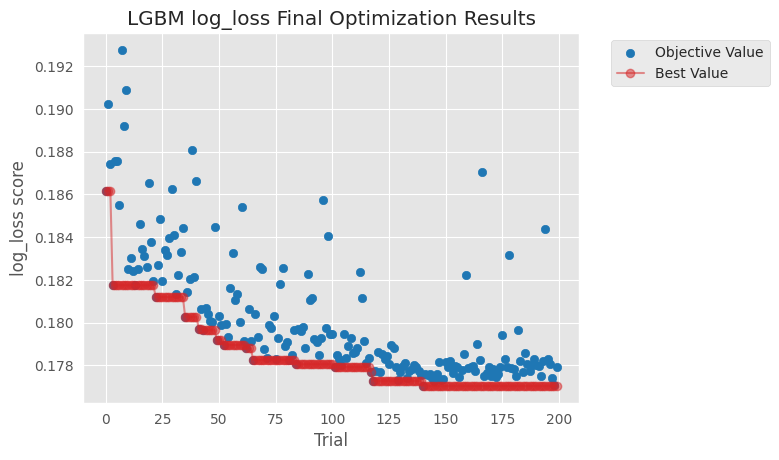

In [151]:
show_study_results(study = "lgbm_log_loss_study_2.pkl", title = "LGBM log_loss Final Optimization Results")

There was some significant progress since the first round, and we've achieved almost the same score as in the baseline model. The question is did we improved the overfitting of the model. Let's first optimize all models and we will see about that!

In [152]:
def catboost_log_loss_objective(trial, X, y, splits):

    param_grid = {
        "classifier__n_estimators": trial.suggest_categorical("n_estimators", [100]),
        "classifier__learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
        "classifier__l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 0.001, 100),
        "classifier__colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1, log = True),
        "classifier__depth": trial.suggest_int("depth", 1, 12),
        "classifier__grow_policy": trial.suggest_categorical("grow_policy", ["SymmetricTree", "Depthwise", "Lossguide"]),
        "classifier__bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "classifier__min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step = 100),
        "classifier__early_stopping_rounds": trial.suggest_categorical("early_stopping_rounds", [100])
    }
    # Conditional Hyper-Parameters
    if param_grid["classifier__grow_policy"] == "SymmetricTree":
        param_grid["classifier__boosting_type"] = trial.suggest_categorical("boosting_type", ["Ordered", "Plain"])
        
    if param_grid["classifier__bootstrap_type"] == "Bayesian":
        param_grid["classifier__bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
        
    elif param_grid["classifier__bootstrap_type"] == "Bernoulli":
        param_grid["classifier__subsample"] = trial.suggest_float("subsample", 0.1, 1)
        
    cv = KFold(n_splits = splits, shuffle = True, random_state = 42, )
    cv_scores = np.empty(splits)

    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        pipeline = Pipeline([
            ("scaler", MinMaxScaler()),
            ("classifier", CatBoostClassifier(
                verbose = 0,
                eval_metric = "Logloss",
            ))
        ])

        pipeline.set_params(**param_grid)
        pipeline.fit(X_train, y_train)

        preds = pipeline.predict(X_test)
        cv_scores[idx] = brier_score_loss(y_test, preds)

    return np.mean(cv_scores)

In [153]:
# catboost_log_loss_study = optuna.create_study(
#     direction = "minimize", study_name = "CatBoost log_loss Optimization"
# )

# func = lambda trial: catboost_log_loss_objective(
#     trial, 
#     X = audio_features, 
#     y = gender_label, 
#     splits = 5
# )

# catboost_log_loss_study.optimize(func, n_trials = 200)

# joblib.dump(catboost_log_loss_study, "catboost_log_loss_study.pkl")

In [154]:
catboost_study_1 = joblib.load("catboost_log_loss_study.pkl")
fig = optuna.visualization.plot_slice(catboost_study_1)
fig.show()

We see already that we had scores around 0.07 log_loss which is more than twice better than the baseline results. CatBoost shows a lot of improvement after tuning and now we have a clear picture of the ranges for the second round.

In [155]:
def catboost_log_loss_objective_2(trial, X, y, splits):

    param_grid = {
        "classifier__n_estimators": trial.suggest_categorical("n_estimators", [100]),
        "classifier__learning_rate": trial.suggest_loguniform("learning_rate", 0.2, 0.7),
        "classifier__l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 3, 35),
        "classifier__colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.08, 0.2, log = True),
        "classifier__depth": trial.suggest_int("depth", 11, 12),
        "classifier__grow_policy": trial.suggest_categorical("grow_policy", ["SymmetricTree", "Depthwise"]),
        "classifier__bootstrap_type": trial.suggest_categorical("bootstrap_type", ["MVS"]),
        "classifier__min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2400, 5000),
        "classifier__early_stopping_rounds": trial.suggest_categorical("early_stopping_rounds", [100])
    }
    # Conditional Hyper-Parameters
    if param_grid["classifier__grow_policy"] == "SymmetricTree":
        param_grid["classifier__boosting_type"] = trial.suggest_categorical("boosting_type", ["Plain"])

        
    cv = KFold(n_splits = splits, shuffle = True, random_state = 42, )
    cv_scores = np.empty(splits)

    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        pipeline = Pipeline([
            ("scaler", MinMaxScaler()),
            ("classifier", CatBoostClassifier(
                verbose = 0,
                eval_metric = "Logloss",
            ))
        ])

        pipeline.set_params(**param_grid)
        pipeline.fit(X_train, y_train)

        preds = pipeline.predict(X_test)
        cv_scores[idx] = brier_score_loss(y_test, preds)

    return np.mean(cv_scores)

In [156]:
# catboost_log_loss_study_2 = optuna.create_study(
#     direction = "minimize", study_name = "CatBoost log_loss Optimization - 2"
# )

# func = lambda trial: catboost_log_loss_objective_2(
#     trial, 
#     X = audio_features, 
#     y = gender_label, 
#     splits = 5
# )

# catboost_log_loss_study_2.optimize(func, n_trials = 200)

# joblib.dump(catboost_log_loss_study_2, "catboost_log_loss_study_2.pkl")

	Best value (rmse): 0.06678
	Best params:
		n_estimators: 100
		learning_rate: 0.30003908438448723
		l2_leaf_reg: 26
		colsample_bylevel: 0.19625942059831306
		depth: 12
		grow_policy: SymmetricTree
		bootstrap_type: MVS
		min_data_in_leaf: 4306
		early_stopping_rounds: 100
		boosting_type: Plain


(None,)

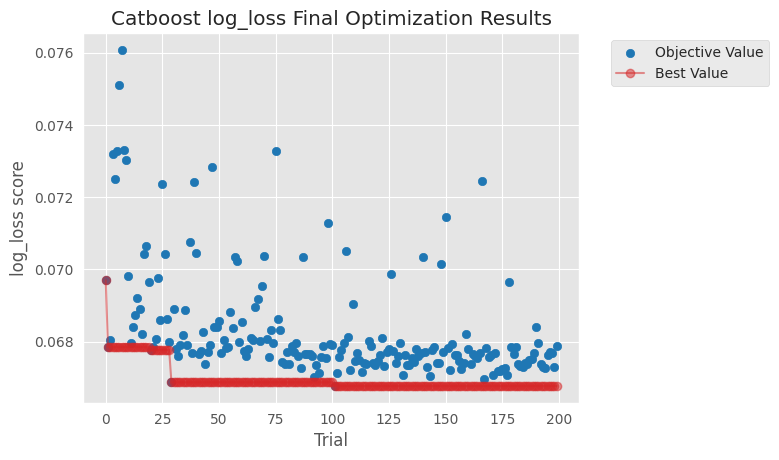

In [157]:
show_study_results(study = "catboost_log_loss_study_2.pkl", title = "Catboost log_loss Final Optimization Results"),

In [158]:
def xgboost_log_loss_objective(trial, X, y, splits):

    param_grid = {
        "classifier__n_estimators": trial.suggest_categorical("n_estimators", [100]),
        "classifier__eta": trial.suggest_float("eta", 0.01, 0.5),
        "classifier__max_depth": trial.suggest_int("max_depth", 3, 12),
        "classifier__gamma": trial.suggest_float("gamma", 0.01, 10),
        "classifier__colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 0.9),
        "classifier__colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1, log = True),
        "classifier__min_child_weight": trial.suggest_int("min_child_weight", 1, 12),
        "classifier__subsample": trial.suggest_float("subsample", 0.4, 0.9),
        "classifier__alpha": trial.suggest_float("alpha", 1e-5, 100),
        "classifier__lambda": trial.suggest_float("lambda", 1e-5, 100),
        "classifier__grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    }
    
    if param_grid["classifier__grow_policy"] == "lossguide":
        param_grid["classifier__max_leaves"] = trial.suggest_int("max_leaves", 0, 2000, step = 20)

    cv = KFold(n_splits = splits, shuffle = True, random_state = 42)
    cv_scores = np.empty(splits)

    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        pipeline = Pipeline([
            ("scaler", MinMaxScaler()),
            ("classifier", XGBClassifier(
                objective = "binary:logistic",
                n_jobs = -1,
                tree_method = "gpu_hist"
                
            ))
        ])

        pipeline.set_params(**param_grid)
        pipeline.fit(X_train, y_train)

        preds = pipeline.predict_proba(X_test)
        cv_scores[idx] = log_loss(y_test, preds)

    return np.mean(cv_scores)

In [159]:
# xgboost_log_loss_study = optuna.create_study(direction = "minimize", study_name = "XGBoost log_loss Optimization")

# func = lambda trial: xgboost_log_loss_objective(
#     trial, 
#     X = audio_features, 
#     y = gender_label, 
#     splits = 5
# )

# xgboost_log_loss_study.optimize(func, n_trials = 200)

# joblib.dump(xgboost_log_loss_study, "xgboost_log_loss_study.pkl")

In [160]:
xgb_study_1 = joblib.load("xgboost_log_loss_study.pkl")
fig = optuna.visualization.plot_slice(xgb_study_1)
fig.show()

In [161]:
def xgboost_log_loss_objective_2(trial, X, y, splits):

    param_grid = {
        "classifier__n_estimators": trial.suggest_categorical("n_estimators", [100]),
        "classifier__eta": trial.suggest_float("eta", 0.35, 0.45),
        "classifier__max_depth": trial.suggest_int("max_depth", 6, 10),
        "classifier__gamma": trial.suggest_float("gamma", 0.03, 1),
        "classifier__colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.7),
        "classifier__colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.02, 0.04, log = True),
        "classifier__min_child_weight": trial.suggest_float("min_child_weight", 1, 2),
        "classifier__subsample": trial.suggest_float("subsample", 0.65, 0.9),
        "classifier__alpha": trial.suggest_float("alpha", 1e-2, 15),
        "classifier__lambda": trial.suggest_float("lambda", 60, 80),
        "classifier__grow_policy": trial.suggest_categorical("grow_policy", ["depthwise"])
    }
    

    cv = KFold(n_splits = splits, shuffle = True, random_state = 42)
    cv_scores = np.empty(splits)

    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        pipeline = Pipeline([
            ("scaler", MinMaxScaler()),
            ("classifier", XGBClassifier(
                objective = "binary:logistic",
                n_jobs = -1,
                tree_method = "gpu_hist"
                
            ))
        ])

        pipeline.set_params(**param_grid)
        pipeline.fit(X_train, y_train)

        preds = pipeline.predict_proba(X_test)
        cv_scores[idx] = log_loss(y_test, preds)

    return np.mean(cv_scores)

In [162]:
# xgboost_log_loss_study_2 = optuna.create_study(direction = "minimize", study_name = "XGBoost log_loss Optimization - 2")

# func = lambda trial: xgboost_log_loss_objective_2(
#     trial, 
#     X = audio_features, 
#     y = gender_label, 
#     splits = 5
# )

# xgboost_log_loss_study_2.optimize(func, n_trials = 200)

# joblib.dump(xgboost_log_loss_study_2, "xgboost_log_loss_study_2.pkl")

	Best value (rmse): 0.18885
	Best params:
		n_estimators: 100
		eta: 0.4318976226557566
		max_depth: 10
		gamma: 0.033369283920056114
		colsample_bytree: 0.6432257499080325
		colsample_bylevel: 0.03771788264578421
		min_child_weight: 1.14466050786121
		subsample: 0.8239322106814413
		alpha: 0.31543633667576654
		lambda: 60.367795316988165
		grow_policy: depthwise


(None,)

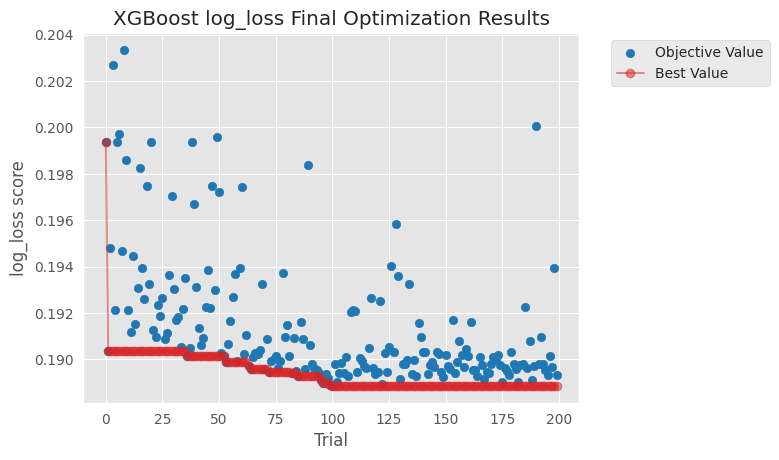

In [163]:
show_study_results(study = "xgboost_log_loss_study_2.pkl", title = "XGBoost log_loss Final Optimization Results"),

There was some improvement in the score, something is something, as they say :)


<br>

## 10. Model Evaluation

Let's introduce the results from our tuning into our models and see what we've achieved.

In [164]:
tuned_models = [

    LGBMClassifier(
        objective = "binary",
        n_estimators = 100,
        learning_rate = 0.31,
        num_leaves = 1600,
        max_depth = 11,
        min_data_in_leaf = 103,
        lambda_l1 = 6,
        lambda_l2 = 46,
        min_gain_to_split = 0.069,
        bagging_fraction = 0.797,
        bagging_freq = 1,
        feature_fraction = 0.58,
        n_jobs = -1, 
        force_col_wise = True,
        verbose = 0
    ),

    CatBoostClassifier(
        n_estimators = 100,
        learning_rate = 0.3,
        l2_leaf_reg = 26,
        colsample_bylevel = 0.196,
        depth = 12,
        grow_policy = "SymmetricTree",
        bootstrap_type = "MVS",
        min_data_in_leaf = 4306,
        boosting_type = "Plain",
        verbose = 0,
#         task_type = "GPU"
    ),

    XGBClassifier(
        n_estimators = 100,
        eta = 0.432,
        max_depth = 10,
        gamma = 0.0333,
        colsample_bytree = 0.64,
        colsample_bylevel = 0.0377,
        min_child_weight = 1.147,
        subsample = 0.824,
        reg_alpha = 0.315,
        reg_lambda = 60.37,
        grow_policy = "depthwise",
        objective = "binary:logistic",
        eval_metric = "logloss",
#         predictor = "gpu_predictor",
#         tree_method = "gpu_hist"
    )
]

In [165]:
# plot_log_loss_learning_curve(
#     data = final_data_transformed_reduced,
#     target = "gender",
#     model = tuned_models[0],
#     title_end = "Optimized Models",
#     img_name = "learning_curve_lgbm_optimized.png"
# )

# plot_log_loss_learning_curve(
#     data = final_data_transformed_reduced,
#     target = "gender",
#     model = tuned_models[1],
#     title_end = "Optimized Models",
#     img_name = "learning_curve_catboost_optimized.png"
# )

# plot_log_loss_learning_curve(
#     data = final_data_transformed_reduced,
#     target = "gender",
#     model = tuned_models[2],
#     title_end = "Optimized Models",
#     img_name = "learning_curve_xgboost_optimized.png"
# )

In [166]:
# plot_log_loss_learning_curve(
#     data = final_data_transformed_reduced,
#     target = "gender",
#     model = tuned_models[0],
#     title_end = "Optimized Model + PCA",
#     img_name = "learning_curve_lgbm_optimized_pca.png",
#     pca = True
# )

# plot_log_loss_learning_curve(
#     data = final_data_transformed_reduced,
#     target = "gender",
#     model = tuned_models[1],
#     title_end = "Optimized Model + PCA",
#     img_name = "learning_curve_catboost_optimized_pca.png",
#     pca = True
# )

# plot_log_loss_learning_curve(
#     data = final_data_transformed_reduced,
#     target = "gender",
#     model = tuned_models[2],
#     title_end = "Optimized Model + PCA",
#     img_name = "learning_curve_xgboost_optimized_pca.png",
#     pca = True
# )

And now let's create an unbalanced dataset to test our models when the classes are not equal or nearly equal.

In [167]:
female_sample = final_data_transformed_reduced[final_data_transformed_reduced.gender == 0].iloc[:25000]
male_sample = final_data_transformed_reduced[final_data_transformed_reduced.gender == 1].iloc[:75000]

In [168]:
sets = [female_sample, male_sample]
imbalanced_sample = pd.concat(sets)

In [169]:
imbalanced_sample.gender.value_counts()

1    75000
0    25000
Name: gender, dtype: int64

In [170]:
# plot_log_loss_learning_curve(
#     data = imbalanced_sample,
#     target = "gender",
#     model = tuned_models[0],
#     title_end = "Optimized Model - Imbalanced Data",
#     img_name = "learning_curve_lgbm_optimized_imbalanced.png",
# )

# plot_log_loss_learning_curve(
#     data = imbalanced_sample,
#     target = "gender",
#     model = tuned_models[1],
#     title_end = "Optimized Model - Imbalanced Data",
#     img_name = "learning_curve_catboost_optimized_imbalanced.png",
#     pca = True
# )

# plot_log_loss_learning_curve(
#     data = imbalanced_sample,
#     target = "gender",
#     model = tuned_models[2],
#     title_end = "Optimized Model - Imbalanced Data",
#     img_name = "learning_curve_xgboost_optimized_imbalanced.png",
#     pca = True
# )

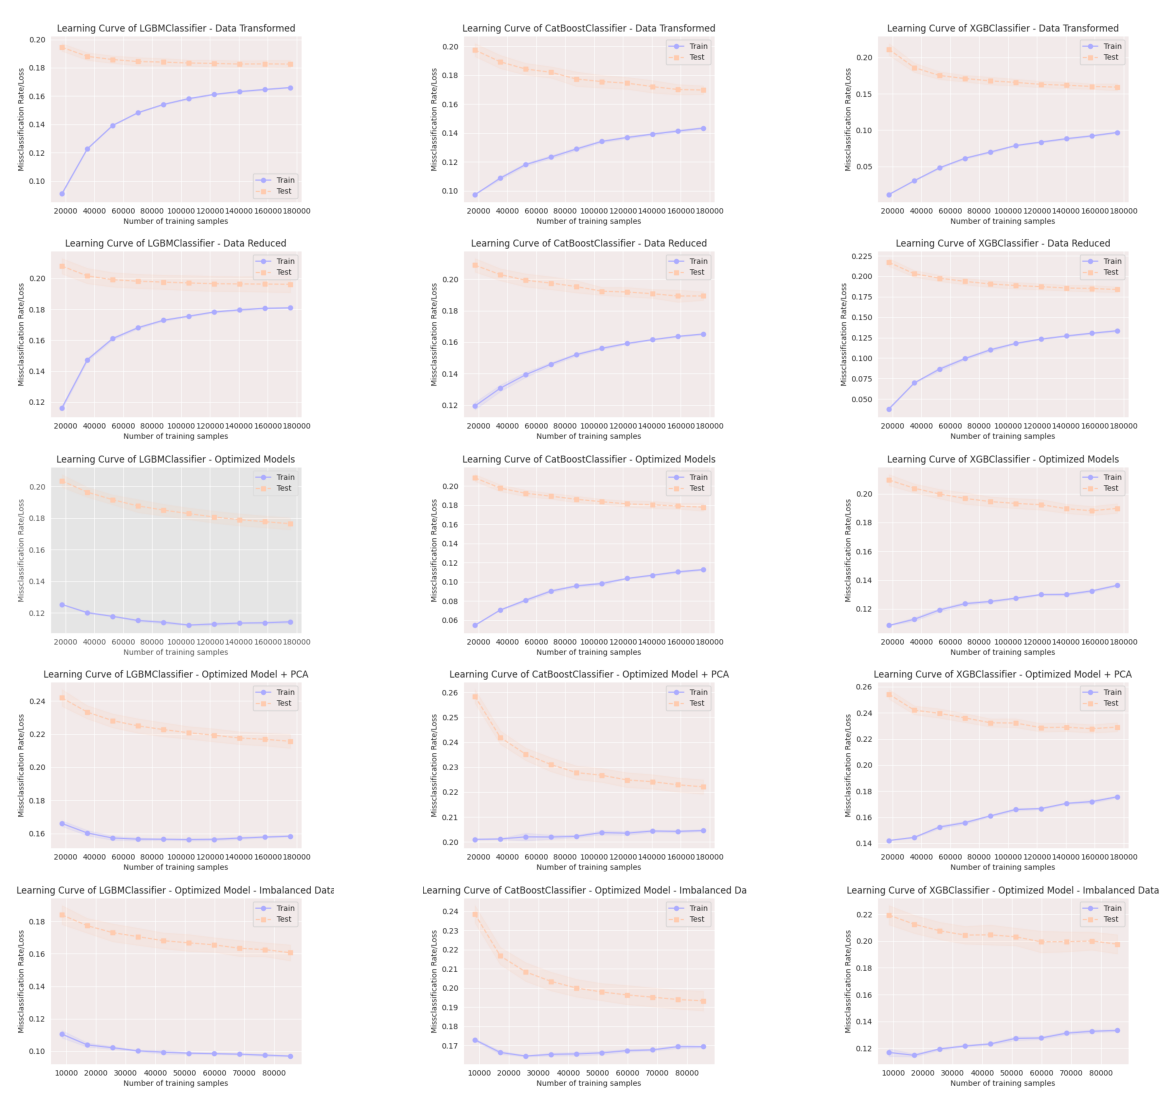

In [171]:
display_multiple_images(
    img_list = [
        "learning_curve_lgbm_data_transformed.png",
        "learning_curve_catboost_data_transformed.png",
        "learning_curve_xgboost_data_transformed.png",
        "learning_curve_lgbm_data_transformed_reduced.png",
        "learning_curve_catboost_data_transformed_reduced.png",
        "learning_curve_xgboost_data_transformed_reduced.png",
        "learning_curve_lgbm_optimized.png",
        "learning_curve_catboost_optimized.png",
        "learning_curve_xgboost_optimized.png",
        "learning_curve_lgbm_optimized_pca.png",
        "learning_curve_catboost_optimized_pca.png",
        "learning_curve_xgboost_optimized_pca.png",
        "learning_curve_lgbm_optimized_imbalanced.png",
        "learning_curve_catboost_optimized_imbalanced.png",
        "learning_curve_xgboost_optimized_imbalanced.png"
    ],
    n_rows = 5,
    n_cols = 3,
    fig_size = (16, 14)
)

### 10. 1 Interpreting the results

####  LGBM

1. At the first and the second plot, before applying optimization, LGBM shows similar results:

    - Training Loss - strong signs of overfiting, due to a low training loss at the beginning which gradually increases upon adding training examples and doesn’t start to flatten until 160-180,000 samples are reached. Adding more examples is unlikely to improve the training error.
    
    - Validation Loss - a high validation loss at the beginning which gradually decreases with a slow constant rate upon adding training, indicating that addition of more training examples will probably improve the performance of the model on unseeen data, but will reach it's limit soon, maybe after another 50,000 samples.
    
    -> Those two models show relatively low bias and low variance, due to the nature of the curves and the value of the Loss error.
    
    

2. Plots number 3 - 5 of the first column, the ones with tuning and PCA and imbalanced data are different though:

    - The Training Loss - a good fit model has a moderately high training loss at the beginning which gradually decreases upon adding training examples and flattens, indicating that the addition of more training examples wouldn't improve the model performance on training data. The model with PCA has the training loss increasing after 70,000 training samples and it might increase more.
    
    - The Test Loss - The rate of improvement here is stronger here, indicating that adding more examples to the training data would improve our model. We can project (roughly) that the Loss might reach 0.15-16 with another 100-200,000 samples and then it will probably flatten, in the best case scenario.
    
    - Interesting enough, there is lower error with less data, which is imbalanced. Meaning that our model doesn't handle large amounts of data too well, or there is something to be adjusted in order to do so.
    
    -> There seems to be more variance in this model.
    

3. Applying PCA created more bias in the model, it just worsened the Loss score, therefore PCA is not really working well for this model, and we might look for different methods for dimensionality reduction.


4. We can conlude that optimizing LGBM gave us better results in therms of overfitting, and the Loss remained more or less the same as with the baseline models.


#### CatBoost

1. Generally, there seems to be more variance in the first two models (in comparisson to LGBM), and relatively low bias.

    - There is room for improvement here with more samples, probably the variance will be reduced, but the Test Loss will remain more or less the same.


2. Things get a bit worse in the optimized model, where variance is gettin geven stronger.


3. Models 4 and 5 though (with PCA and imbalanced data) are showing much better results, generally, this is how a good fit must look like:

    - Therefore, we can conclued that PCA works well with our CatBoost model and it might be implemented in a pipeline.
    
    
#### XGBoost

1. Nearly identical curves to CatBoost (for the first 3 models), except that it has even stronger variance.


2. It doesn't seem to improve with PCA, and it has the worst performance on the imbalanced data of them all.

    - There's not much more to say about it.
    
    
#### Let's have a final look at the ROC curves and the confusion matrices of the imbalanced data:

In [172]:
# plot_confusion(
#     model = tuned_models[0],
#     data = imbalanced_sample,
#     target = "gender",
#     img_name = "conf_matrix_lgbm_optimized_imbalanced.png"
# )

# plot_confusion(
#     model = tuned_models[1],
#     data = imbalanced_sample,
#     target = "gender",
#     img_name = "conf_matrix_catboost_optimized_imbalanced.png"
# )

# plot_confusion(
#     model = tuned_models[2],
#     data = imbalanced_sample,
#     target = "gender",
#     img_name = "conf_matrix_xgboost_optimized_imbalanced.png"
# )

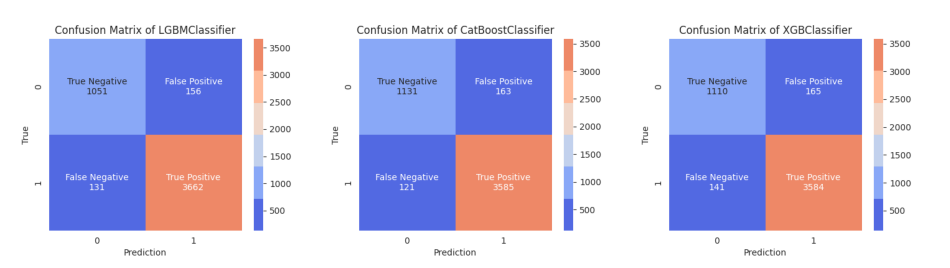

In [173]:
display_multiple_images(
    img_list = [
        "conf_matrix_lgbm_optimized_imbalanced.png",
        "conf_matrix_catboost_optimized_imbalanced.png",
        "conf_matrix_xgboost_optimized_imbalanced.png"
    ],
    n_rows = 1,
    n_cols = 3,
    fig_size = (12, 4),
)

As we see, the predictions are quite good, given the big disbalance that we created in our data. We can say that our models work well.

That's great to see!

In [174]:
# plot_roc_curve(
#     model = tuned_models[0],
#     data = imbalanced_sample,
#     target = "gender",
#     img_name = "roc_curve_lgbm_optimized_imbalanced.png"
# )

# plot_roc_curve(
#     model = tuned_models[1],
#     data = imbalanced_sample,
#     target = "gender",
#     img_name = "roc_curve_catboost_optimized_imbalanced.png"
# )

# plot_roc_curve(
#     model = tuned_models[2],
#     data = imbalanced_sample,
#     target = "gender",
#     img_name = "roc_curve_xgboost_optimized_imbalanced.png"
# )

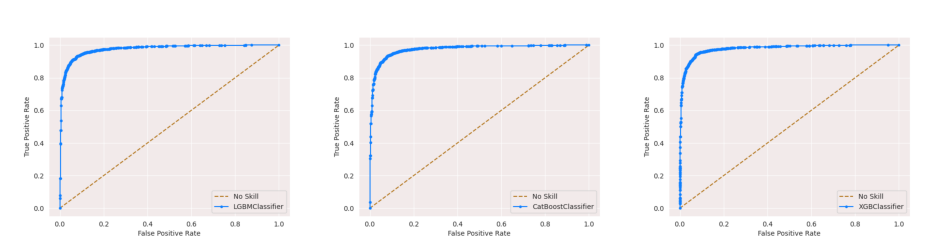

In [175]:
display_multiple_images(
    img_list = [
        "roc_curve_lgbm_optimized_imbalanced.png",
        "roc_curve_catboost_optimized_imbalanced.png",
        "roc_curve_xgboost_optimized_imbalanced.png"
    ],
    n_rows = 1,
    n_cols = 3,
    fig_size = (12, 4),
)

There is no visible change in the ROC curves, they still appear very good looking, with a big AUC area.

OK...

<br>

## 11. Summary

Let's discuss briefly what was improved or changed from the previous research on which this project is based on:

1. We have managed to extract more and better quality features, and only by doing this we have achieved results that almost doubled the 0.50 accuracy and f1 scores that our colleague Michael P. Notter presented.


2. We have managed to reduce our features from 137 to 25, conserving all the valuable information that's in our data and understanding that MFCC features are more than enough for our models to classify a gender.


3. We have log-transformed our data (same as in the original project), but we also applied PCA to reduce more of the noise and the "dimensionality curse".


4. Then, we have trained and tested various models, using 5+ cross validation to ensure the validity of our results.


5. Optimizing our models was productive and reduced the bias and the variance in some of them, and (at least) it didn't make it worse in the others.


6. As our top performer we are selecting CatBoost, it is showing much more potential for improvement. Second place goes for LGBM and third for XGBoost.


7. All the models achieved great scores, proving their versatility and reputation.



### 11. 1 To improve

There is much more that can, and should be done, in order to confirm our results and achieve better scores. As a start it will be good to go through all our selected features and see how they relate to the data, which of them create more bias, and can we remove even more of them to improve it.

We can also create different conditions for our models, using audio data augmentation and, for example, if it handles well audios with a lot of background noise.


And whatever comes to our creative minds... :)


### Thanks for the read!


All the sources on which this project relied are linked in the noteboook.